# **Data Analytics Competition FIND IT 2023 - Introduction**
Swine flu, caused by the H1N1 flu virus, is a type of influenza A virus that can cause seasonal flu. Its symptoms are similar to those of seasonal flu. During the 2009-2010 flu season, the H1N1 virus caused a respiratory tract infection in humans known as swine flu, leading the WHO to declare it a pandemic. The H1N1 flu virus became one of the strains that cause seasonal flu after the pandemic ended.

Flu vaccines are now available to protect against H1N1 flu. COVID-19 is also categorized as a seasonal flu disease and is delaying efforts to produce a vaccine for seasonal flu.

The data set we are using represents individuals from the **2009 National H1N1 Flu Survey (NHFS)** conducted by the CDC.<br><br>

## **Goals and Evaluation:**

The goal of our analysis is to predict the likelihood of people getting H1N1 flu and receiving their yearly flu vaccine. We will specifically forecast two probabilities: one for the **H1N1 vaccine** and one for the **seasonal flu vaccine**.

The performance of the model will be measured using the area under the receiver operating characteristic curve **(ROC AUC)** for each of the two target variables. The overall score will be calculated by taking the mean of these two scores. A **higher score** indicates better performance.

**Made by BukanRISTEK**
- Fathi Qushoyyi Ahimsa
- Edward Salim
- Muhammad Fakhri Robbani

<hr><hr>

# **Load Libraries**

In [1]:
!pip install --q optuna
!pip install --q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.5 MB/s eta 0:00:00


In [2]:
# Utilities
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)                      # Set the option to display all columns in pandas

# Google colab
from google.colab import drive 
drive.mount('/content/drive')                                   # Mount the Google Drive in Google Colab

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineering
from sklearn.feature_selection import mutual_info_classif as mic  # Import mutual_info_classif for feature selection
from sklearn.impute import SimpleImputer                          # Import SimpleImputer for missing value imputation

# Modeling
import optuna                                                   # Import optuna library for hyperparameter optimization
from sklearn.model_selection import KFold                       # Import KFold for cross-validation
from sklearn.metrics import roc_auc_score as ras                # Import roc_auc_score for evaluation metric
from sklearn.model_selection import cross_val_score             # Import cross_val_score for cross-validation
from sklearn.model_selection import GridSearchCV                # Import GridSearchCV for grid search
from sklearn.model_selection import RandomizedSearchCV          # Import RandomizedSearchCV for randomized search

# Models
from sklearn.linear_model import LogisticRegression             
from sklearn.tree import DecisionTreeClassifier                 
from sklearn.ensemble import RandomForestClassifier             
from sklearn.neighbors import KNeighborsClassifier              
from sklearn.naive_bayes import GaussianNB                      
from sklearn.svm import SVC                                     
from sklearn.neural_network import MLPClassifier                
import xgboost as xgb                                           
import lightgbm as lgbm                                         
import catboost as cb                                           

Mounted at /content/drive


# **1. Data Wrangling**
To kick off the analysis, we will begin with data wrangling, which encompasses a series of tasks including data cleaning, data transformation, data integration, and data reduction. Through these processes, we aim to ensure the accuracy, completeness, and analyzability of the dataset.
### **1.1 Load Dataset**

In [3]:
train_feature = pd.read_csv("/content/drive/MyDrive/DAC-FINDIT/training_set_features.csv", index_col="respondent_id")
train_label = pd.read_csv("/content/drive/MyDrive/DAC-FINDIT/training_set_labels.csv", index_col="respondent_id") 
sample_submission = pd.read_csv("/content/drive/MyDrive/DAC-FINDIT/submission_format.csv", index_col="respondent_id")

In [4]:
train = train_feature.merge(train_label, on='respondent_id') # Merge train_feature and train_label
test = pd.read_csv("/content/drive/MyDrive/DAC-FINDIT/test_set_features.csv", index_col="respondent_id")

In [5]:
train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


Upon examining the given dataframe, it is evident that all the columns in the dataset are categorical in nature.

### **1.2 Data Inspection**

In [6]:
print(f"Train shape: {train.shape}")  # See number of rows and columns in train dataset
print(f"Test shape: {test.shape}")    # See number of rows and columns in test dataset

Train shape: (26707, 37)
Test shape: (26708, 35)


In [7]:
train.info() # Displays a summary of the dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

We'll create a function to evaluate the missing value proportions in the train and test datasets. This function will facilitate the assessment of missing data and simplify future missing value checks.

In [8]:
def missing_values(train, test):
    miss_perc_df = pd.DataFrame (
        index=['train_miss','test_miss'],   # Set index of dataframe
        columns=test.columns,               # Set columns of dataframe
    )

    # Loop through the columns of the "test" dataframe and calculate the percentage of missing values for both the "train" and "test" dataframes
    for i, col in enumerate(test.columns):
        miss_perc_df.loc['train_miss', col] = np.round(train.isna().sum()[i] / train[col].shape[0] * 100, 2)  # Calculate missing values in train dataset
        miss_perc_df.loc['test_miss', col] = np.round(test.isna().sum()[i] / test[col].shape[0] * 100, 2)     # Calculate missing values in test dataset

    # Convert the values in the "miss_perc_df" dataframe to strings and append a "%" sign
    miss_perc_df = miss_perc_df.astype(str) + "%"
    return miss_perc_df

In [9]:
missing_values(train, test)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
train_miss,0.34%,0.43%,0.27%,0.78%,0.07%,0.16%,0.33%,0.31%,0.48%,8.09%,8.09%,3.64%,3.07%,3.01%,45.96%,1.46%,1.45%,1.48%,1.73%,1.92%,2.01%,0.0%,5.27%,0.0%,0.0%,16.56%,5.27%,7.65%,5.48%,0.0%,0.0%,0.93%,0.93%,49.91%,50.44%
test_miss,0.32%,0.46%,0.3%,0.8%,0.07%,0.15%,0.27%,0.31%,0.48%,8.09%,8.09%,3.49%,3.04%,2.95%,45.78%,1.49%,1.42%,1.4%,1.69%,1.87%,1.95%,0.0%,5.27%,0.0%,0.0%,16.84%,5.4%,7.62%,5.51%,0.0%,0.0%,0.84%,0.84%,49.7%,50.27%


From the given dataframe, we can gather the following information:
* The columns `health_insurance`, `employment_industry`, and `employment_occupation` contain a significant number of missing values.
* The `income_poverty` column also has a considerable amount of missing data.
* The `doctor_recc_h1n1` and `doctor_recc_seasonal` columns share the same proportion of missing values.

Since the columns with the dtype `float64` are already ordinal encoded, we can directly utilize them as features for our machine learning models without any additional preprocessing.

To streamline the preprocessing of our data, we will segregate the columns into two separate variables based on their types: ordinal and nominal. This division will enable us to apply specific preprocessing techniques more efficiently to the nominal columns.

In [10]:
# Select columns from the 'train' dataframe that have a data type of float64 and convert them to a list.
ordinal_cols = train.select_dtypes("float64").columns.to_list()
# Select columns from the 'train' dataframe that have a data type of object (strings) and convert them to a list.
object_cols = train.select_dtypes("object").columns.to_list()

behavioral_cols = ["behavioral_antiviral_meds", "behavioral_avoidance", "behavioral_face_mask", "behavioral_wash_hands",
                   "behavioral_large_gatherings", "behavioral_outside_home", "behavioral_touch_face"]

opinion_cols = ["opinion_h1n1_vacc_effective", "opinion_h1n1_risk", "opinion_h1n1_sick_from_vacc",
                "opinion_seas_vacc_effective", "opinion_seas_risk", "opinion_seas_sick_from_vacc"]

Given that all the columns in the dataset are categorical, it would be beneficial to examine the mode for each column. This is particularly important as we are likely to use the mode to impute missing values in our dataset.

In [11]:
# Ordinal columns
ord_summary = train.loc[:, ordinal_cols].describe()
pd.concat([ord_summary, train[ordinal_cols].mode()]).rename(index={0: "mean"})

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
count,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000
mean,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583
std,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000
mean,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,1.000000,1.000000,0.000000


In [12]:
# Nominal columns
train.loc[:, object_cols].describe()

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,employment_industry,employment_occupation
count,26707,25300,26707,26707,22284,25299,24665,25244,26707,26707,13377,13237
unique,5,4,4,2,3,2,2,3,10,3,21,23
top,65+ Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",fcxhlnwr,xtkaffoo
freq,6843,10097,21222,15858,12777,13555,18736,13560,4297,11645,2468,1778


In [13]:
print("Ordinal columns:", len(ordinal_cols))
print("Nominal columns:", len(object_cols))

Ordinal columns: 23
Nominal columns: 12


To compare missing values with other categories, we will create a copy of the train dataframe and fill in all the missing values with "Missing". This will allow us to perform a crosstabular analysis and compare the missing values to other categories more effectively.

In [14]:
nan_to_miss = train.copy()

# Replace all missing values in the 'nan_to_miss' dataframe with the string "Missing"
nan_to_miss.fillna("Missing", inplace=True)

In [15]:
train[train["education"].isna()].tail()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26549,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,35 - 44 Years,NaN,White,Female,NaN,NaN,NaN,NaN,oxchjgsf,Non-MSA,1.0,2.0,NaN,NaN,0,1
26608,2.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65+ Years,NaN,Other or Multiple,Female,NaN,NaN,NaN,NaN,lrircsnp,"MSA, Not Principle City",0.0,0.0,NaN,NaN,0,0
26639,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,0.0,NaN,4.0,4.0,4.0,4.0,1.0,4.0,65+ Years,NaN,Hispanic,Male,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,0
26672,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18 - 34 Years,NaN,Black,Female,NaN,NaN,NaN,NaN,fpwskwrf,"MSA, Principle City",NaN,NaN,NaN,NaN,0,1
26675,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,NaN,4.0,2.0,2.0,4.0,4.0,2.0,45 - 54 Years,NaN,White,Male,NaN,NaN,NaN,NaN,kbazzjca,Non-MSA,1.0,1.0,NaN,NaN,0,1


We observe that the presence of a missing value in the `education` column is usually accompanied by missing values in the `income_poverty`, `marital_status`, `rent_or_own`, `employment_status`, `employment_industry`, and `employment_occupation` columns.

In [16]:
# Computes a frequency table or contingency table showing the distribution of two categorical variables in the DataFrame
pd.crosstab(nan_to_miss["doctor_recc_h1n1"], nan_to_miss["doctor_recc_seasonal"])

doctor_recc_seasonal,0.0,1.0,Missing
doctor_recc_h1n1,,,
0.0,15659,3480,0
1.0,794,4614,0
Missing,0,0,2160


It is evident that when a row in the `doctor_recc_seasonal` column contains a NaN value, the corresponding row in the `doctor_recc_h1n1` column will also be NaN. This specific missing value pattern holds significant importance and should be captured by our model.

In [17]:
pd.crosstab(nan_to_miss["employment_status"], nan_to_miss["employment_industry"])

employment_industry,Missing,arjwrbjb,atmlpfrs,cfqqtusy,dotnnunm,fcxhlnwr,haxffmxo,ldnlellj,mcubkhph,mfikgejo,msuufmds,nduyfdeo,phxvnwax,pxcmvdjn,qnlwzans,rucpziij,saaquncn,vjjrobsf,wlfvacwt,wxleyezf,xicduogh,xqicxuve
employment_status,,,,,,,,,,,,,,,,,,,,,,
Employed,183,871,926,325,201,2468,148,1231,275,614,124,286,89,1037,13,523,338,527,215,1804,851,511
Missing,1463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Not in Labor Force,10231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Unemployed,1453,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
pd.crosstab(nan_to_miss["employment_status"], nan_to_miss["employment_occupation"])

employment_occupation,Missing,bxpfxfdn,ccgxvspp,cmhcxjea,dcjcmpih,dlvbwzss,emcorrxb,haliazsg,hfxkjkmi,hodpvpew,kldqjyjy,mxkfnird,oijqvulv,pvmttkik,qxajmpny,rcertsgn,tfqavkke,ukymxvdu,uqqtjvyb,vlluhbov,xgwztkwe,xqwwgdyp,xtkaffoo,xzmlyyjv
employment_status,,,,,,,,,,,,,,,,,,,,,,,,
Employed,323,331,341,1247,148,227,1270,296,766,208,469,1509,344,98,548,276,388,372,452,354,1082,485,1778,248
Missing,1463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Not in Labor Force,10231,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Unemployed,1453,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


An intriguing observation is that when a row in the `employment_status` column is missing or when a person is categorized as "Not in Labor Force" or "Unemployed," we can guarantee that the corresponding rows in the `employment_industry` and `employment_occupation` columns will also be missing. This pattern aligns with our expectations and makes logical sense (MNAR).

To preserve and capture the observed pattern, we can introduce a new category (i.e. "None") in the `employment_industry` and `employment_occupation` columns specifically for cases where a person is **not in the labor force** or **unemployed**. By including this new category, we maintain the integrity of the pattern within our data, allowing our model to effectively utilize this information.

### **1.3 Handling Missing Values**

To capture the missing value pattern in the dataset, we will create a new category called "Unknown" for nominal columns and assign a value of 2 as "Unknown" for ordinal columns in both the training and test data. This approach allows us to effectively handle and represent missing values in our dataset without significantly increasing the length of our code.

In [19]:
for df in [train, test]:
    df['doctor_recc_h1n1'].fillna(2.0, inplace=True)
    df['doctor_recc_seasonal'].fillna(2.0, inplace=True)
    df['health_insurance'].fillna(2.0, inplace=True)

    df["education"].fillna("Unknown", inplace=True)
    df["marital_status"].fillna("Unknown", inplace=True)
    df["rent_or_own"].fillna("Unknown", inplace=True)
    df["income_poverty"].fillna("Unknown", inplace=True)

We can safely impute missing values in the `employment_status` column with "Not in Labor Force" because when a row has a missing value in `employment_status`, the corresponding rows in `employment_industry` and `employment_occupation` will also be missing.

This relationship is similar to the cases where the `employment_status` is "Not in Labor Force" or "Unemployed". We choose "Not in Labor Force" as the imputation value because it is the second most frequent value in the column.

In [20]:
for df in [train, test]:
    df['employment_status'].fillna("Not in Labor Force", inplace=True);

In [21]:
for df in [train, test]:
    for row in range(df.index[0], df.index[-1]+1):  # Iterate over the rows of the DataFrame.
        if (df.loc[row, "employment_status"] == "Not in Labor Force") or (df.loc[row, "employment_status"] == "Unemployed"):
            df.loc[row, "employment_occupation"] = "None"  # Set the value of 'employment_occupation' to "None" for the current row.
            df.loc[row, "employment_industry"] = "None"  # Set the value of 'employment_industry' to "None" for the current row.

To avoid introducing bias, we will impute the missing values in the **respondent's opinion columns** with the value 3, which represents "Don't know." This approach ensures that the missing values are treated uniformly and does not influence the analysis based on the respondents' opinions.

In [22]:
for df in [train, test]:
    df[opinion_cols] = df[opinion_cols].fillna(3.0)

In [23]:
missing_values(train, test)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
train_miss,0.34%,0.43%,0.27%,0.78%,0.07%,0.16%,0.33%,0.31%,0.48%,0.0%,0.0%,3.64%,3.07%,3.01%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.93%,0.93%,0.69%,1.21%
test_miss,0.32%,0.46%,0.3%,0.8%,0.07%,0.15%,0.27%,0.31%,0.48%,0.0%,0.0%,3.49%,3.04%,2.95%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.84%,0.84%,0.75%,1.31%


For the remaining missing values in both the train and test datasets, which are **mostly** missing at random (MAR), we will fill them with the mode of each respective column. Since the dataset consists of categorical variables, using the mode as the imputation strategy helps maintain the categorical nature of the data.

In [24]:
imputer = SimpleImputer(strategy='most_frequent')  # Create an instance of SimpleImputer with 'most_frequent' strategy.

# Ordinal Columns
train[ordinal_cols] = imputer.fit_transform(train[ordinal_cols])  # Fill missing values in ordinal columns of 'train' DataFrame using the fitted imputer.
test[ordinal_cols] = imputer.transform(test[ordinal_cols])  # Fill missing values in ordinal columns of 'test' DataFrame using the fitted imputer.

# Nominal Columns
train[object_cols] = imputer.fit_transform(train[object_cols])  # Fill missing values in nominal columns of 'train' DataFrame using the fitted imputer.
test[object_cols] = imputer.transform(test[object_cols])  # Fill missing values in nominal columns of 'test' DataFrame using the fitted imputer.

In [25]:
missing_values(train, test)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
train_miss,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
test_miss,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


### **1.4 Handling Other Issues**

To ensure compatibility with various machine learning algorithms and statistical techniques, we will convert the columns with dtype `float64` to `int64`. This conversion will effectively transform these variables from continuous to discrete, as many algorithms require discrete variables as input. By making these variables discrete, we can leverage the full range of analytical tools and methods available for categorical data analysis.

In [26]:
train[ordinal_cols] = train[ordinal_cols].astype("int64") # Convert train[ordinal_cols] to integer
test[ordinal_cols] = test[ordinal_cols].astype("int64")   # Convert test[ordinal_cols] to integer

In [27]:
print("Train duplicates:", train.duplicated().sum())  # Find duplicates value in train
print("Test duplicates:", test.duplicated().sum())    # Find duplicates value in test

Train duplicates: 1
Test duplicates: 0


The presence of a single duplicated row is negligible and is unlikely to significantly impact the analysis. Therefore, we can safely ignore this duplicated row without compromising the integrity or accuracy of our results.

When categorical variables are represented as ranges or intervals, such as `age_group`, assigning a single value to each category helps in reducing the loss of information and provides a more precise estimate for analysis. By assigning a midpoint, we treat the variable as if it takes on a continuous scale, albeit with some level of discretization.

In [28]:
# Define a dictionary to map age_group categories to numerical values
dict_age_group = {"65+ Years": 75, "55 - 64 Years": 60, "45 - 54 Years": 50, "18 - 34 Years": 26, "35 - 44 Years" : 40}

for df in [train, test]:
    # Replace the values in the age_group column with the corresponding numerical value from dict_age_group
    df['age_group'] = df['age_group'].map(dict_age_group)

To assign a more representative midpoint to the "65+ Years" age category, an approximate value of 75 can be considered. This choice is based on global data trends indicating that the average age at which many people pass away in various countries is approximately 85 years.

Please note that this information is sourced from a study titled "Deaths: final data for 2009" (2011, December 29) available on PubMed. It is important to mention that this specific data is used solely for the purpose of assigning a midpoint to the age group range of 65+ years. https://pubmed.ncbi.nlm.nih.gov/24974587/#:~:text=Life%20expectancy%20at%20birth%20rose,74%2C%20and%2075%2D84.

In [29]:
# Check inconsistency -- Ordinal columns
for col in ordinal_cols:
  print(col + ":", sorted(train[col].unique())) # Print unique values in every columns, sorted

# Check inconsistency -- Object columns
for col in object_cols:
  print(col + ":", train[col].unique())         # Print unique values in every columns
  print()

h1n1_concern: [0, 1, 2, 3]
h1n1_knowledge: [0, 1, 2]
behavioral_antiviral_meds: [0, 1]
behavioral_avoidance: [0, 1]
behavioral_face_mask: [0, 1]
behavioral_wash_hands: [0, 1]
behavioral_large_gatherings: [0, 1]
behavioral_outside_home: [0, 1]
behavioral_touch_face: [0, 1]
doctor_recc_h1n1: [0, 1, 2]
doctor_recc_seasonal: [0, 1, 2]
chronic_med_condition: [0, 1]
child_under_6_months: [0, 1]
health_worker: [0, 1]
health_insurance: [0, 1, 2]
opinion_h1n1_vacc_effective: [1, 2, 3, 4, 5]
opinion_h1n1_risk: [1, 2, 3, 4, 5]
opinion_h1n1_sick_from_vacc: [1, 2, 3, 4, 5]
opinion_seas_vacc_effective: [1, 2, 3, 4, 5]
opinion_seas_risk: [1, 2, 3, 4, 5]
opinion_seas_sick_from_vacc: [1, 2, 3, 4, 5]
household_adults: [0, 1, 2, 3]
household_children: [0, 1, 2, 3]
age_group: [60 40 26 75 50]

education: ['< 12 Years' '12 Years' 'College Graduate' 'Some College' 'Unknown']

race: ['White' 'Black' 'Other or Multiple' 'Hispanic']

sex: ['Female' 'Male']

income_poverty: ['Below Poverty' '<= $75,000, Above P

After careful manual inspection, we have determined that there are no instances of inconsistent data entries in the dataset.

Since the dataset exclusively consists of categorical columns, there is no need for **normalization**. Categorical features do not possess a natural numerical order or scale, rendering normalization irrelevant in this context.

# **2. Exploratory Data Analysis**
### **2.1 Univariate Exploration**
We will begin by directing our attention to comprehending the distribution of categorical data, prioritizing an understanding of its characteristics without delving into its relationship with other variables.

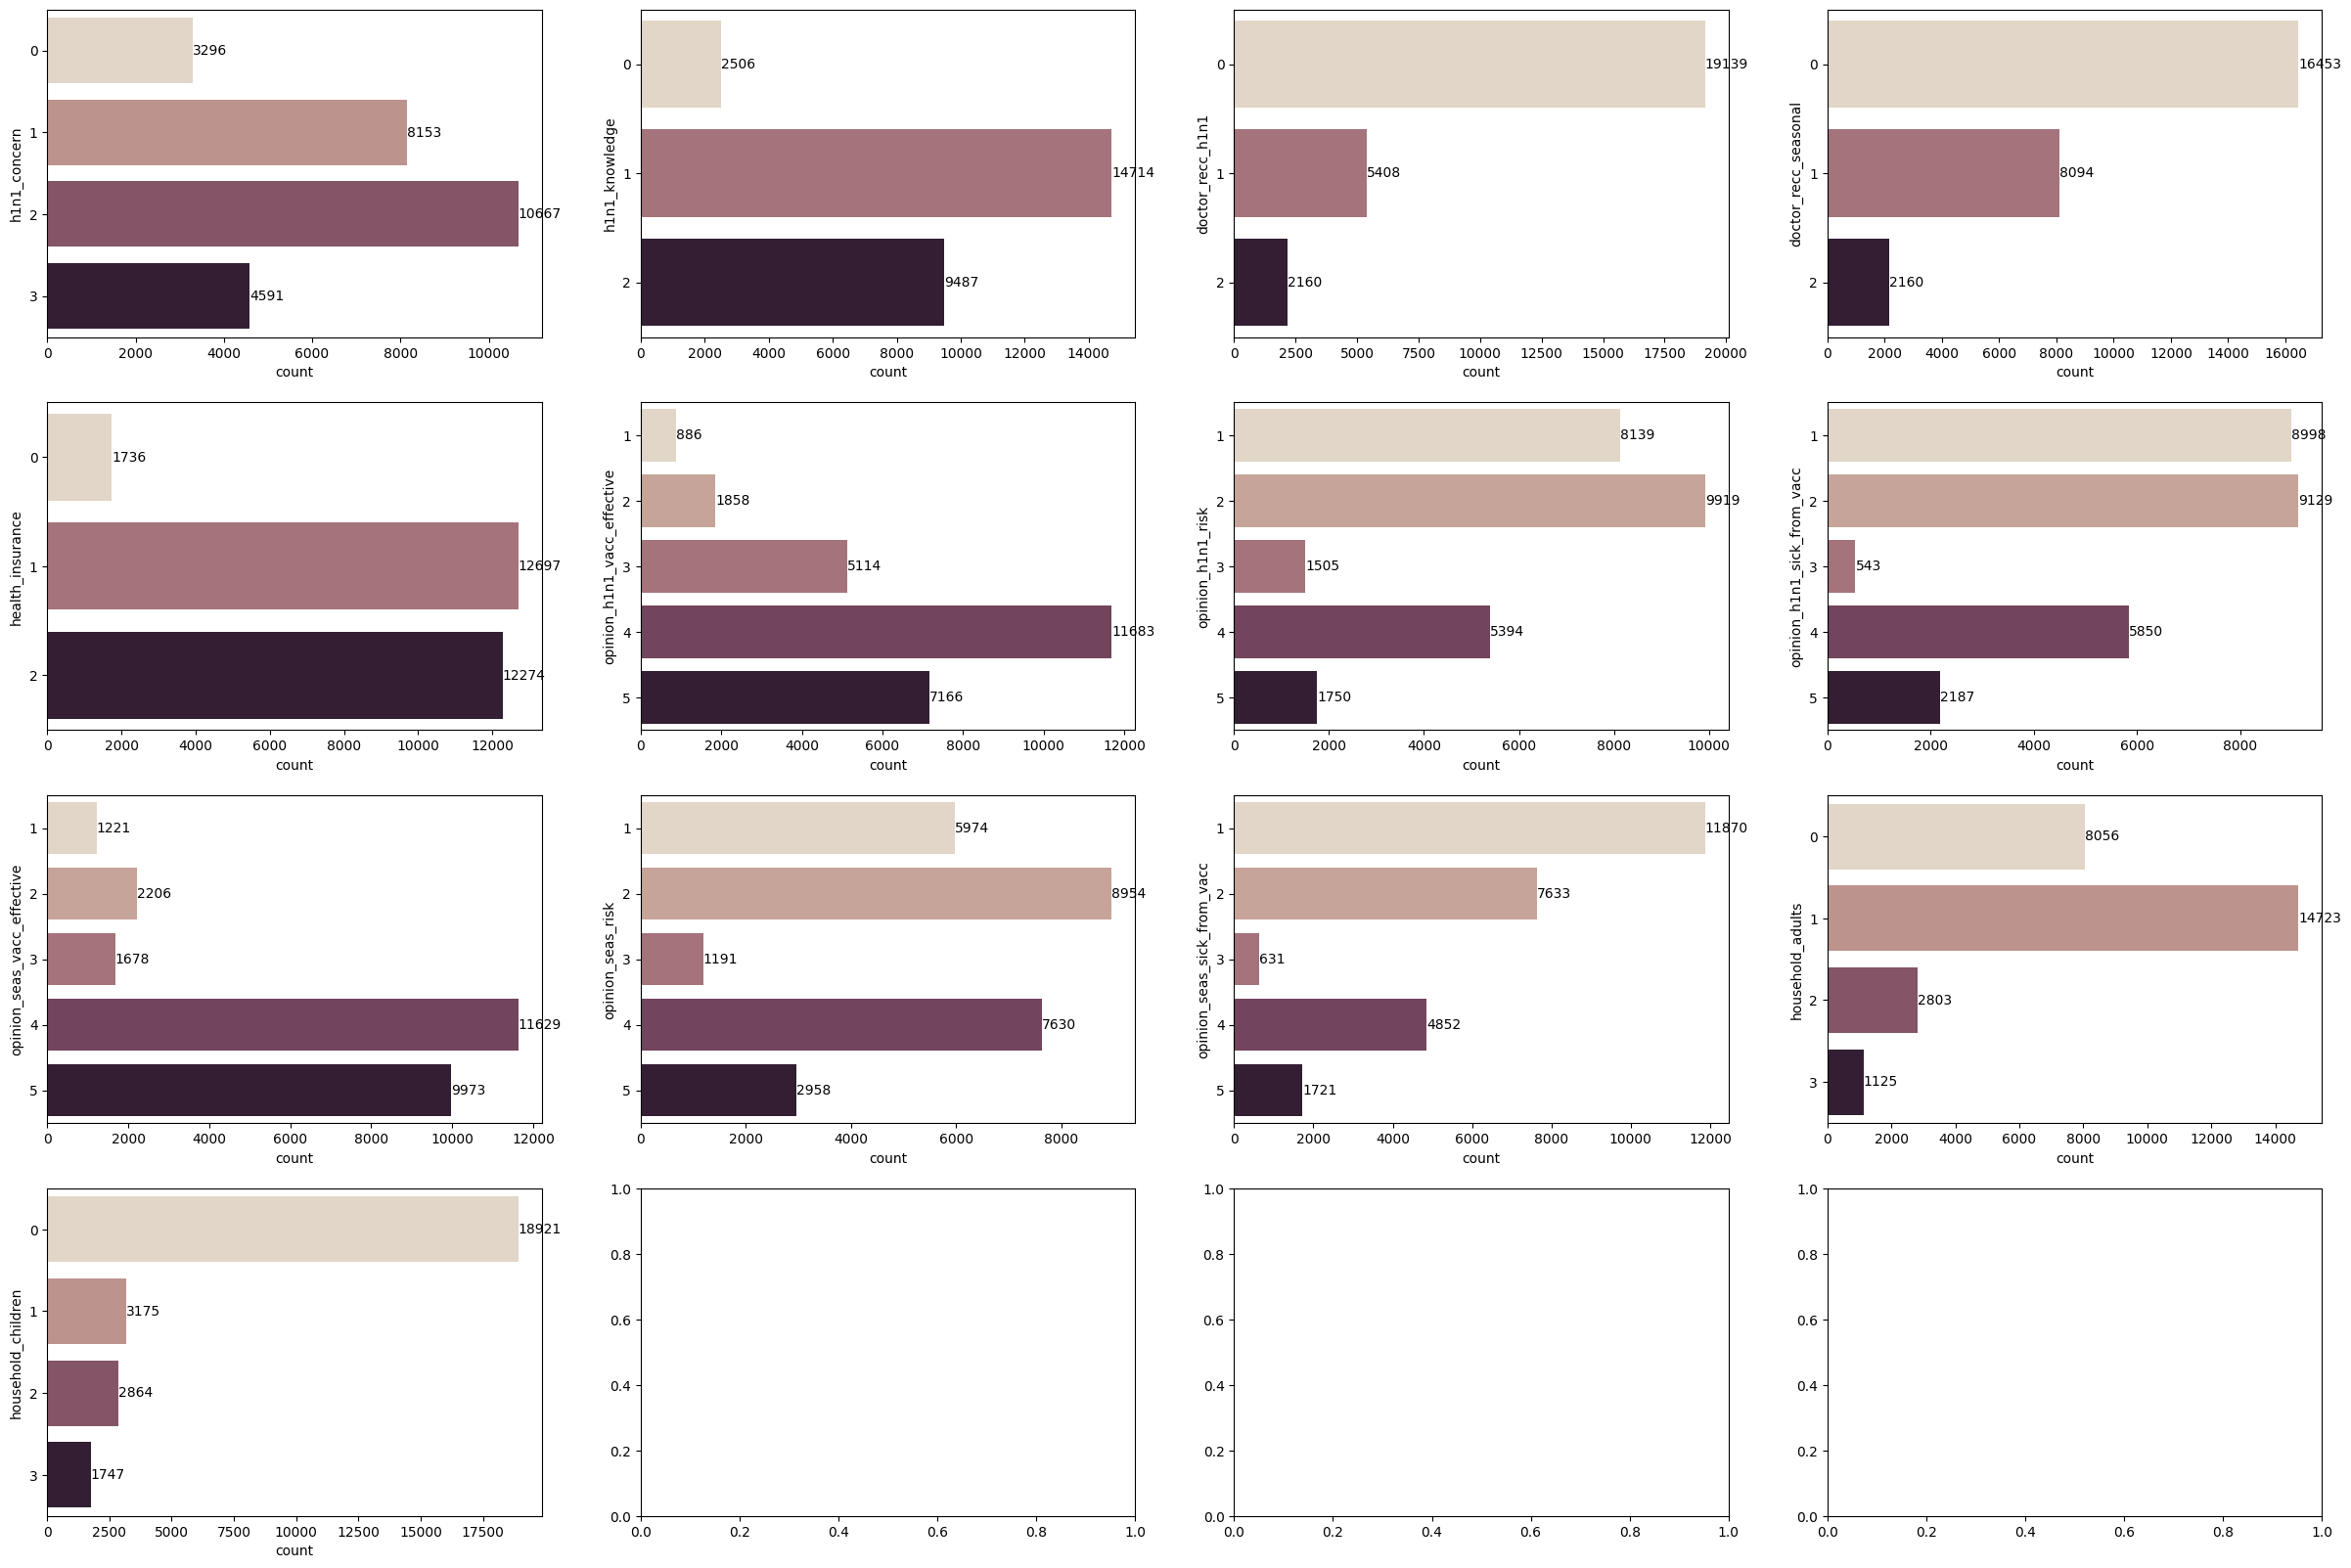

In [30]:
# Select the ordinal columns (non-binary) with more than 2 unique values.
non_binary_cols = [col for col in ordinal_cols if train[col].nunique() > 2]

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(30, 20))  # Creating subplots for countplots with specified dimensions and figure size.

for i, col in enumerate(non_binary_cols):  # Iterate over the non-binary ordinal columns.
    bar = sns.countplot(data=train, y=col, ax=ax[i//4, i%4], palette="ch:.25")  # Create a countplot for each column and assign it to the corresponding subplot.
    bar.bar_label(bar.containers[0])  # Add labels to the bars in the countplot.

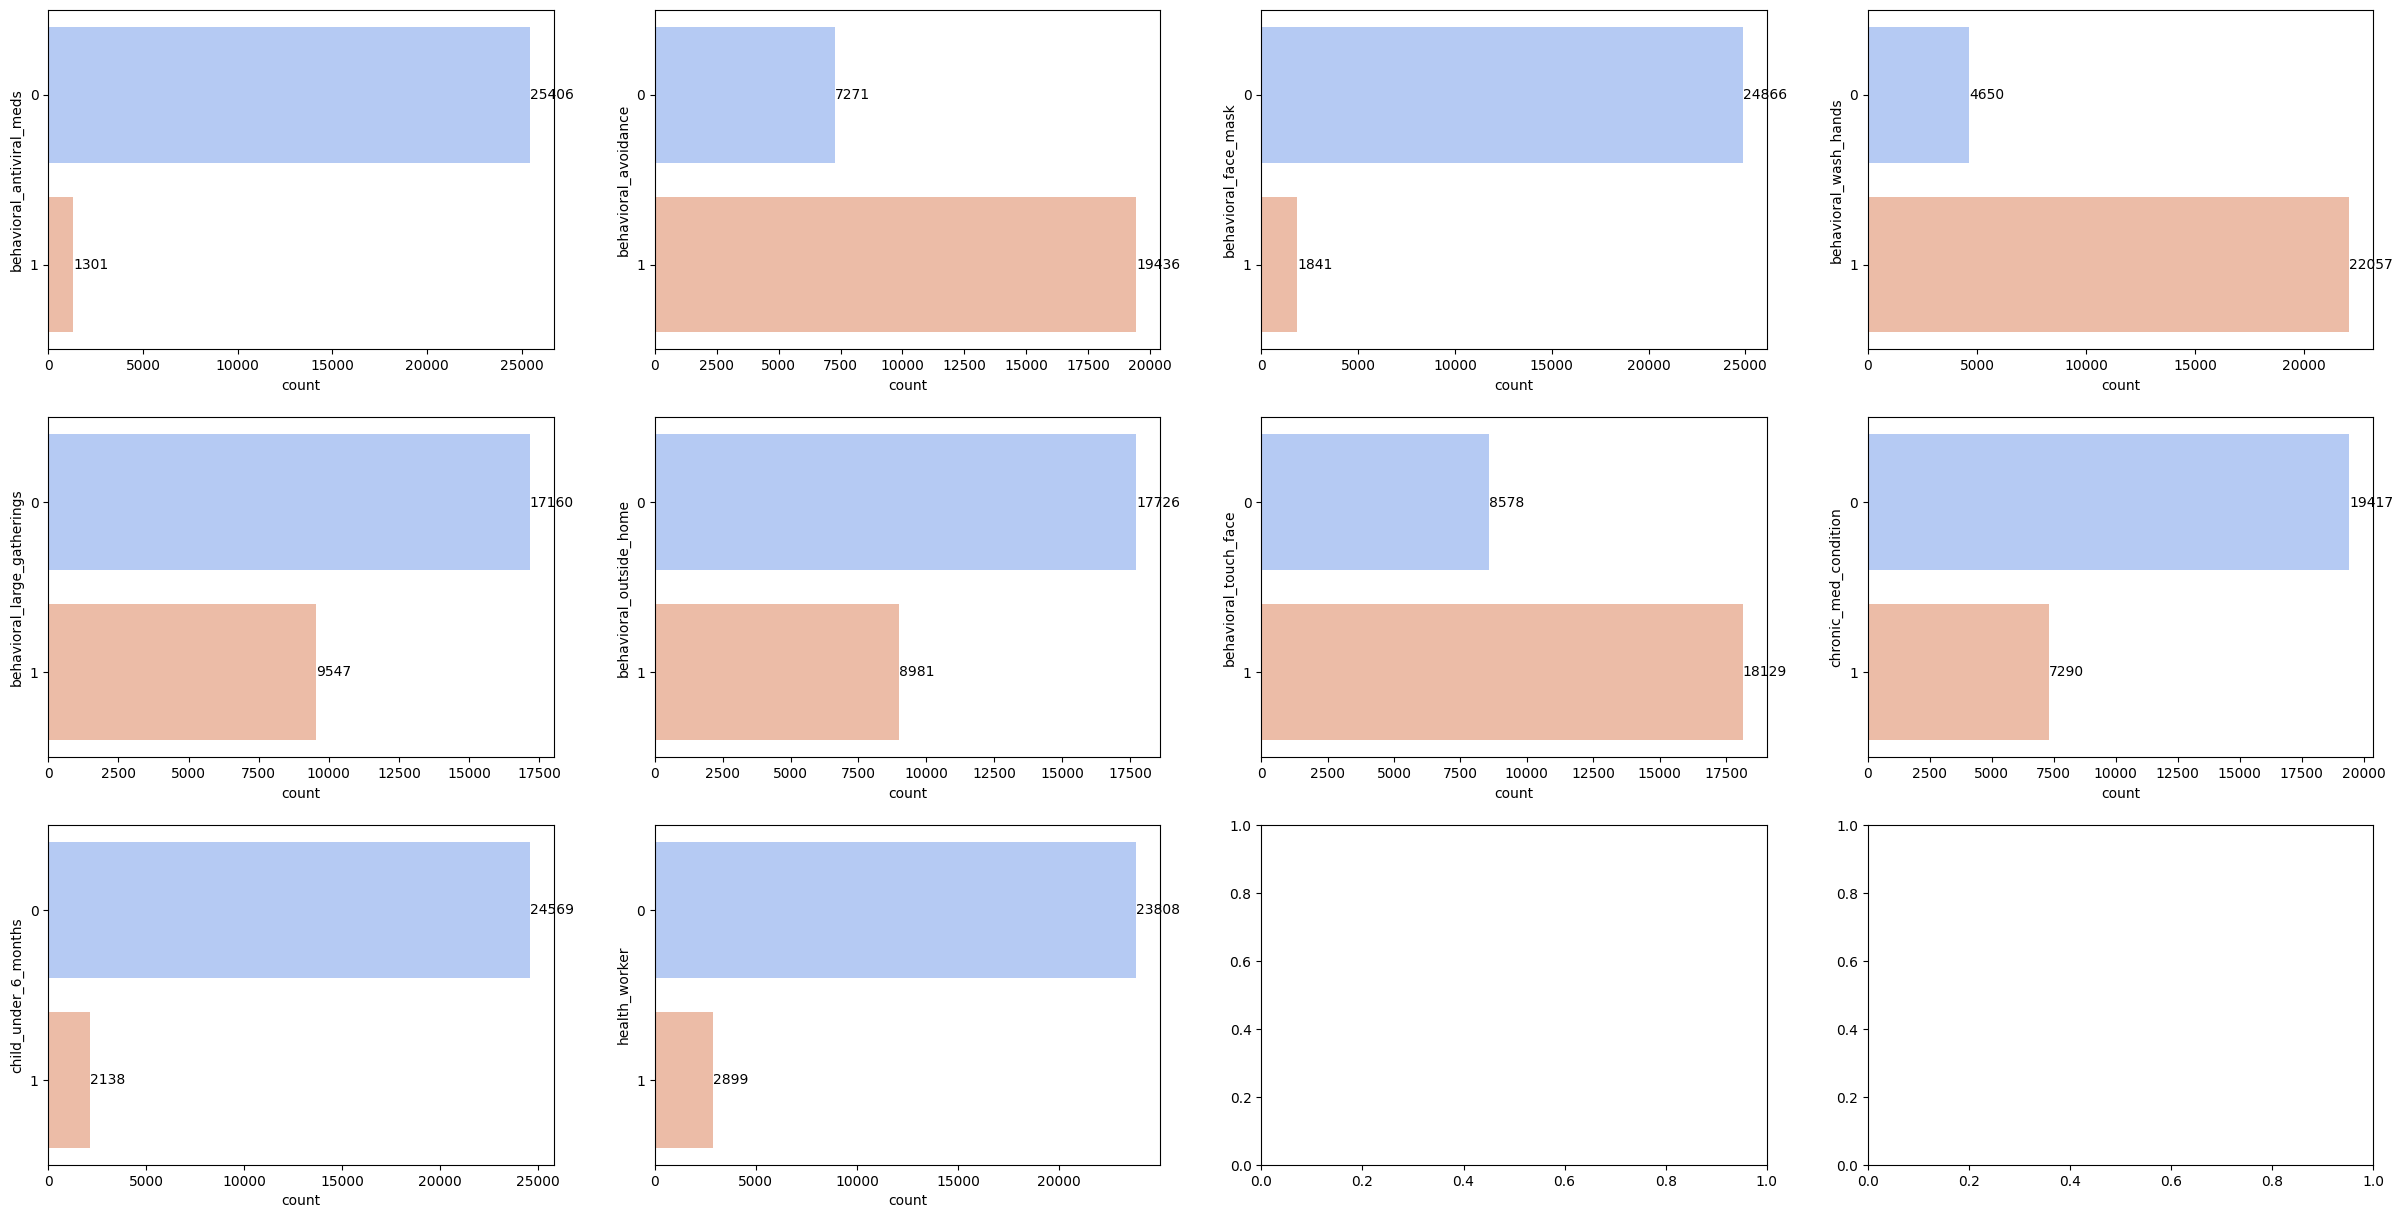

In [31]:
# Select the ordinal columns (binary) with less than or equal to 2 unique values.
binary_cols = [col for col in ordinal_cols if train[col].nunique() <= 2]

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(30, 15))

for i, col in enumerate(binary_cols):
  bar = sns.countplot(data=train, y=col, ax=ax[i//4, i%4], palette="coolwarm")
  bar.bar_label(bar.containers[0])

Considering that the "None" category overwhelmingly dominates all other categories in the `employment_industry` and `employment_occupation` columns, it is apparent that plotting these columns would not yield any valuable insights. Therefore, we will exclude them from our analysis.

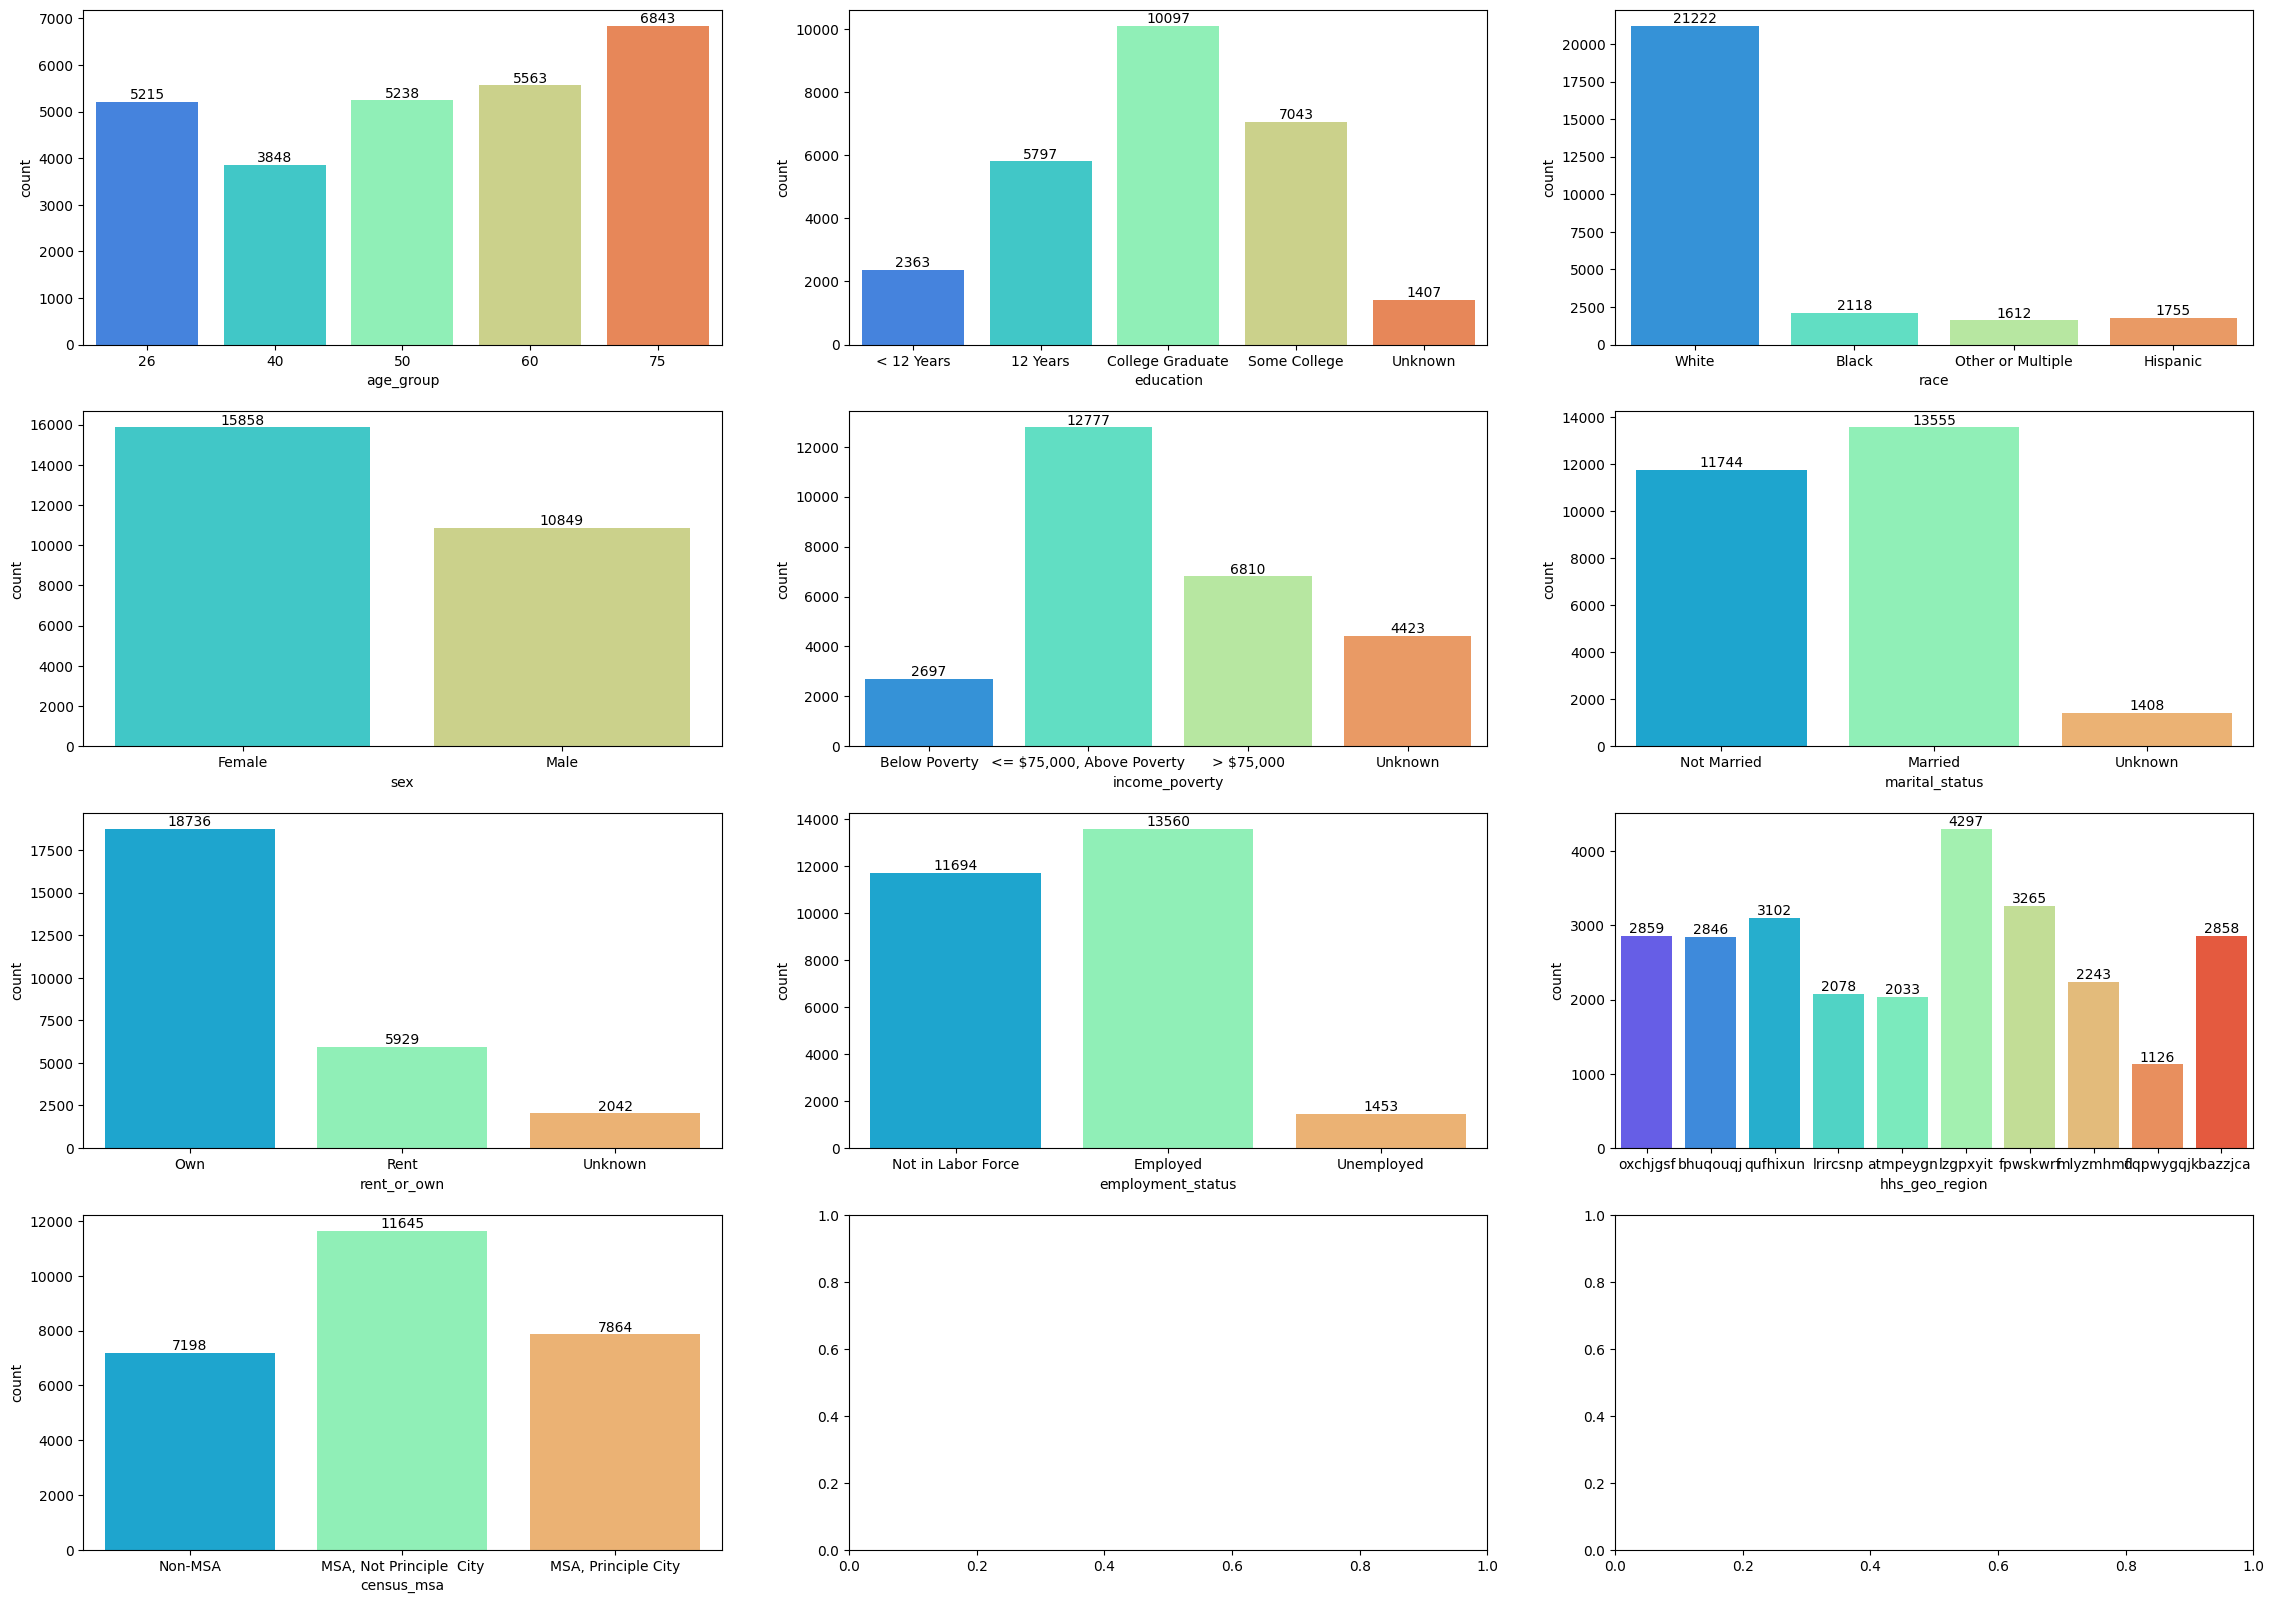

In [32]:
# Countplot for Object columns
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(28, 20))

for i, col in enumerate(object_cols):
    if (col not in ["employment_industry", "employment_occupation"]):
        bar = sns.countplot(data=train, x=col, ax=ax[i//3, i%3], palette="rainbow")
        bar.bar_label(bar.containers[0])

### **2.2. Bivariate Exploration**
Our attention now turns to comprehending the correspondence and relationship between two specific columns, particularly in relation to the target variable. The aim of this endeavor is to gain a deeper understanding of the fundamental patterns and connections inherent within our dataset.

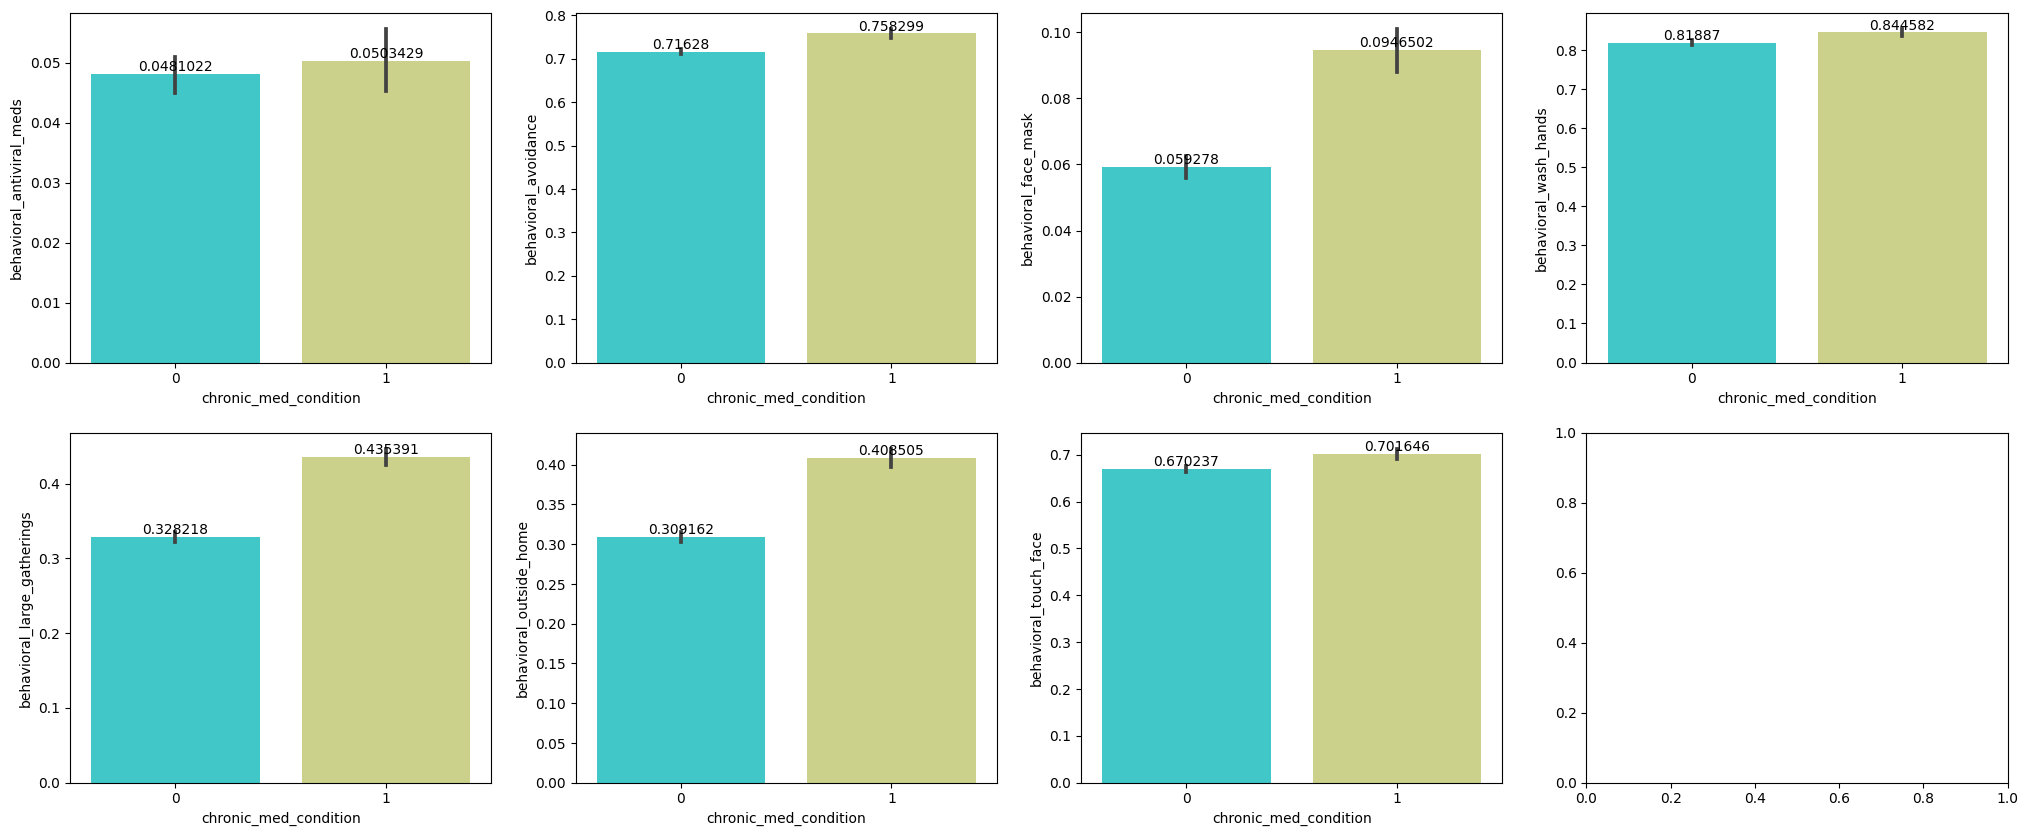

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))

for i, col in enumerate(behavioral_cols):
    bar = sns.barplot(data=train, y=col, x="chronic_med_condition", ax=ax[i//4, i%4], palette="rainbow")
    bar.bar_label(bar.containers[0])

The bar plot indicates a notable pattern where individuals with specific chronic medical conditions, such as asthma, diabetes, heart conditions, kidney conditions, sickle cell anemia, neurological or neuromuscular conditions, liver conditions, or weakened immune systems due to chronic illnesses or medications, tend to exhibit more proactive behavioral precautions to prevent the occurrence of flu-like illnesses.

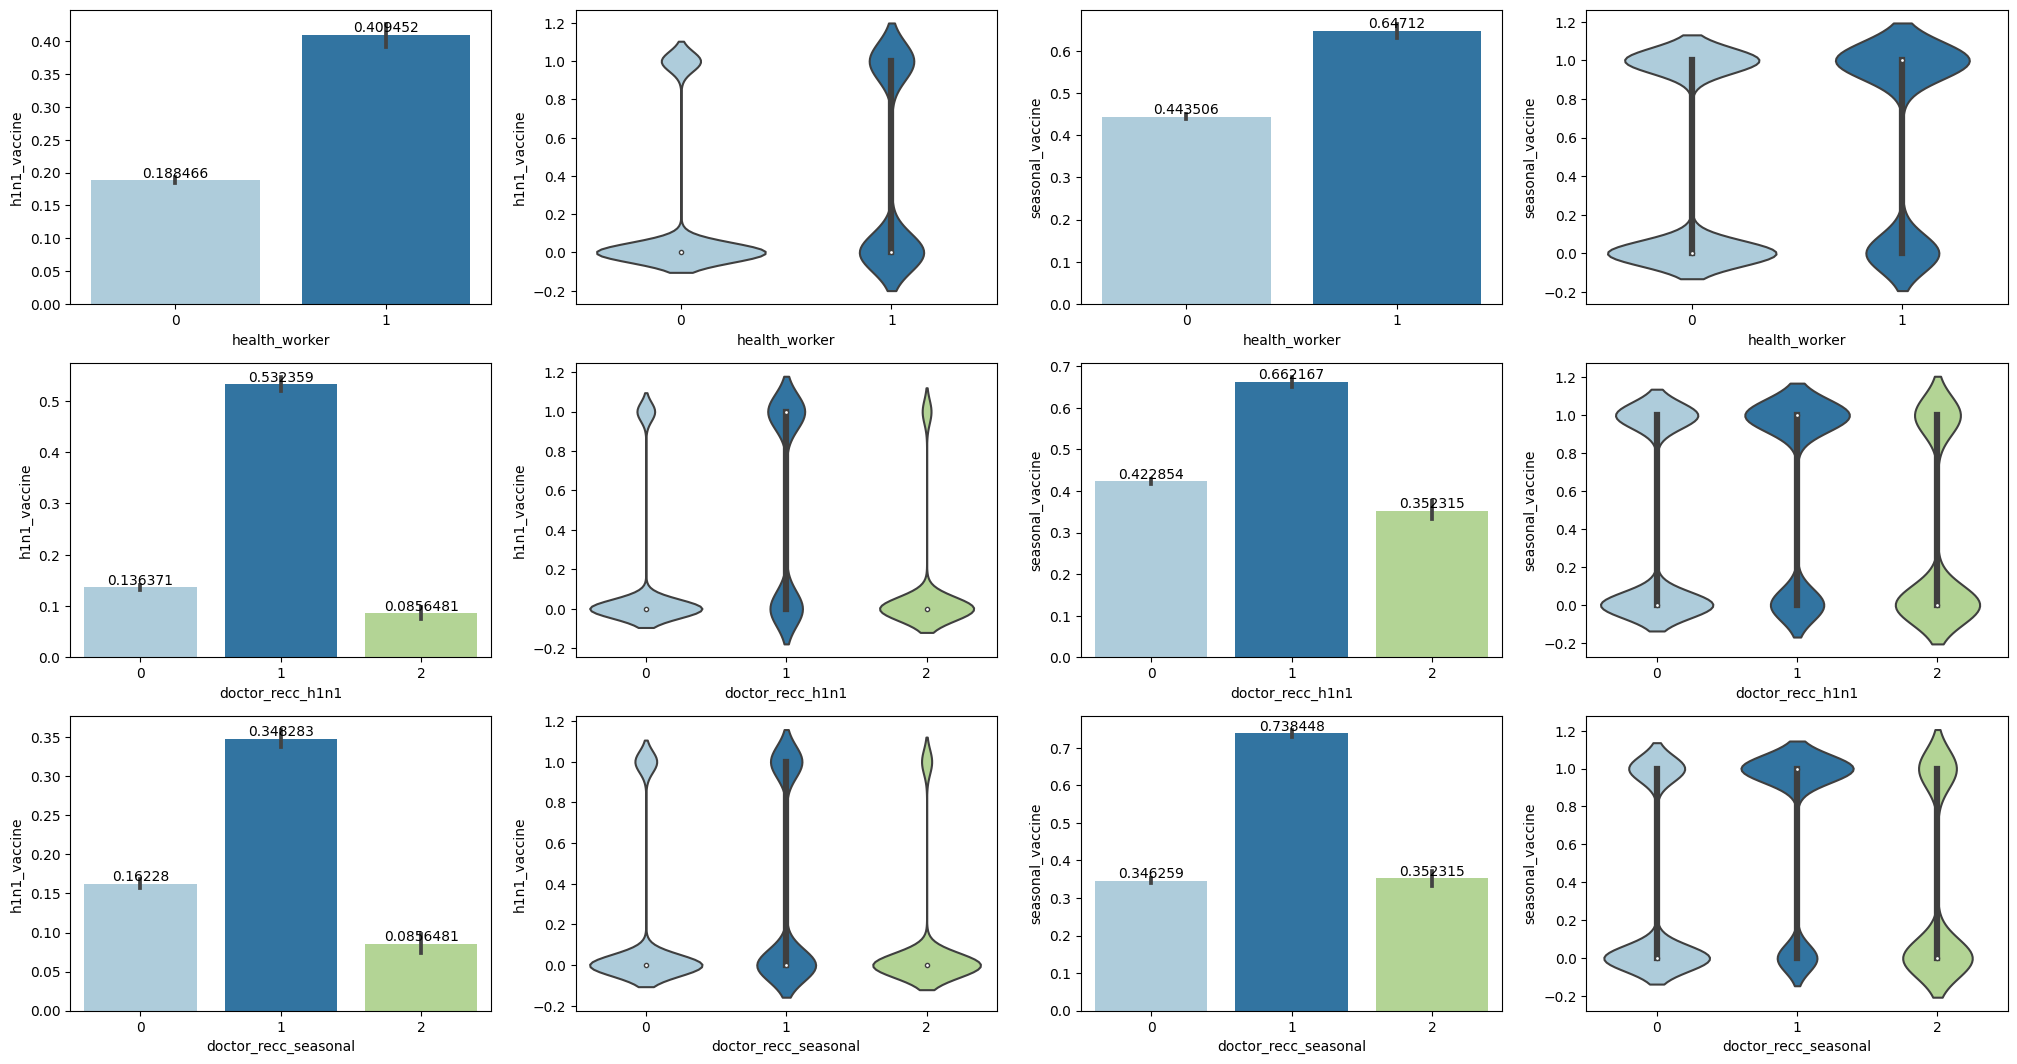

In [34]:
# Create a figure with subplots to plot the barplots and violinplots.
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(25, 13))

# Health related columns
for i, col in enumerate(["health_worker", "doctor_recc_h1n1", "doctor_recc_seasonal"]):
    bar = sns.barplot(data=train, y='h1n1_vaccine', x=col, ax=ax[i, 0], palette="Paired")
    bar.bar_label(bar.containers[0])

    # Plot a violinplot for 'h1n1_vaccine' on the i-th subplot.
    sns.violinplot(data=train, y='h1n1_vaccine', x=col, ax=ax[i, 1], palette="Paired")

    bar = sns.barplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 2], palette="Paired")
    bar.bar_label(bar.containers[0])

    # Plot a violinplot for 'seasonal_vaccine' on the i-th subplot.
    sns.violinplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 3], palette="Paired")

The visualization reveals clear patterns. Healthcare workers are more likely to receive both the H1N1 flu vaccine and the seasonal flu vaccine.

 Similarly, individuals recommended the H1N1 vaccine by a doctor are highly likely to receive both the H1N1 vaccine and the seasonal vaccine. Moreover, those recommended the seasonal vaccine are also highly likely to receive both the seasonal and H1N1 vaccines. These findings highlight the influence of healthcare worker status and doctor recommendations on vaccination behavior, indicating a strong association with vaccine uptake.

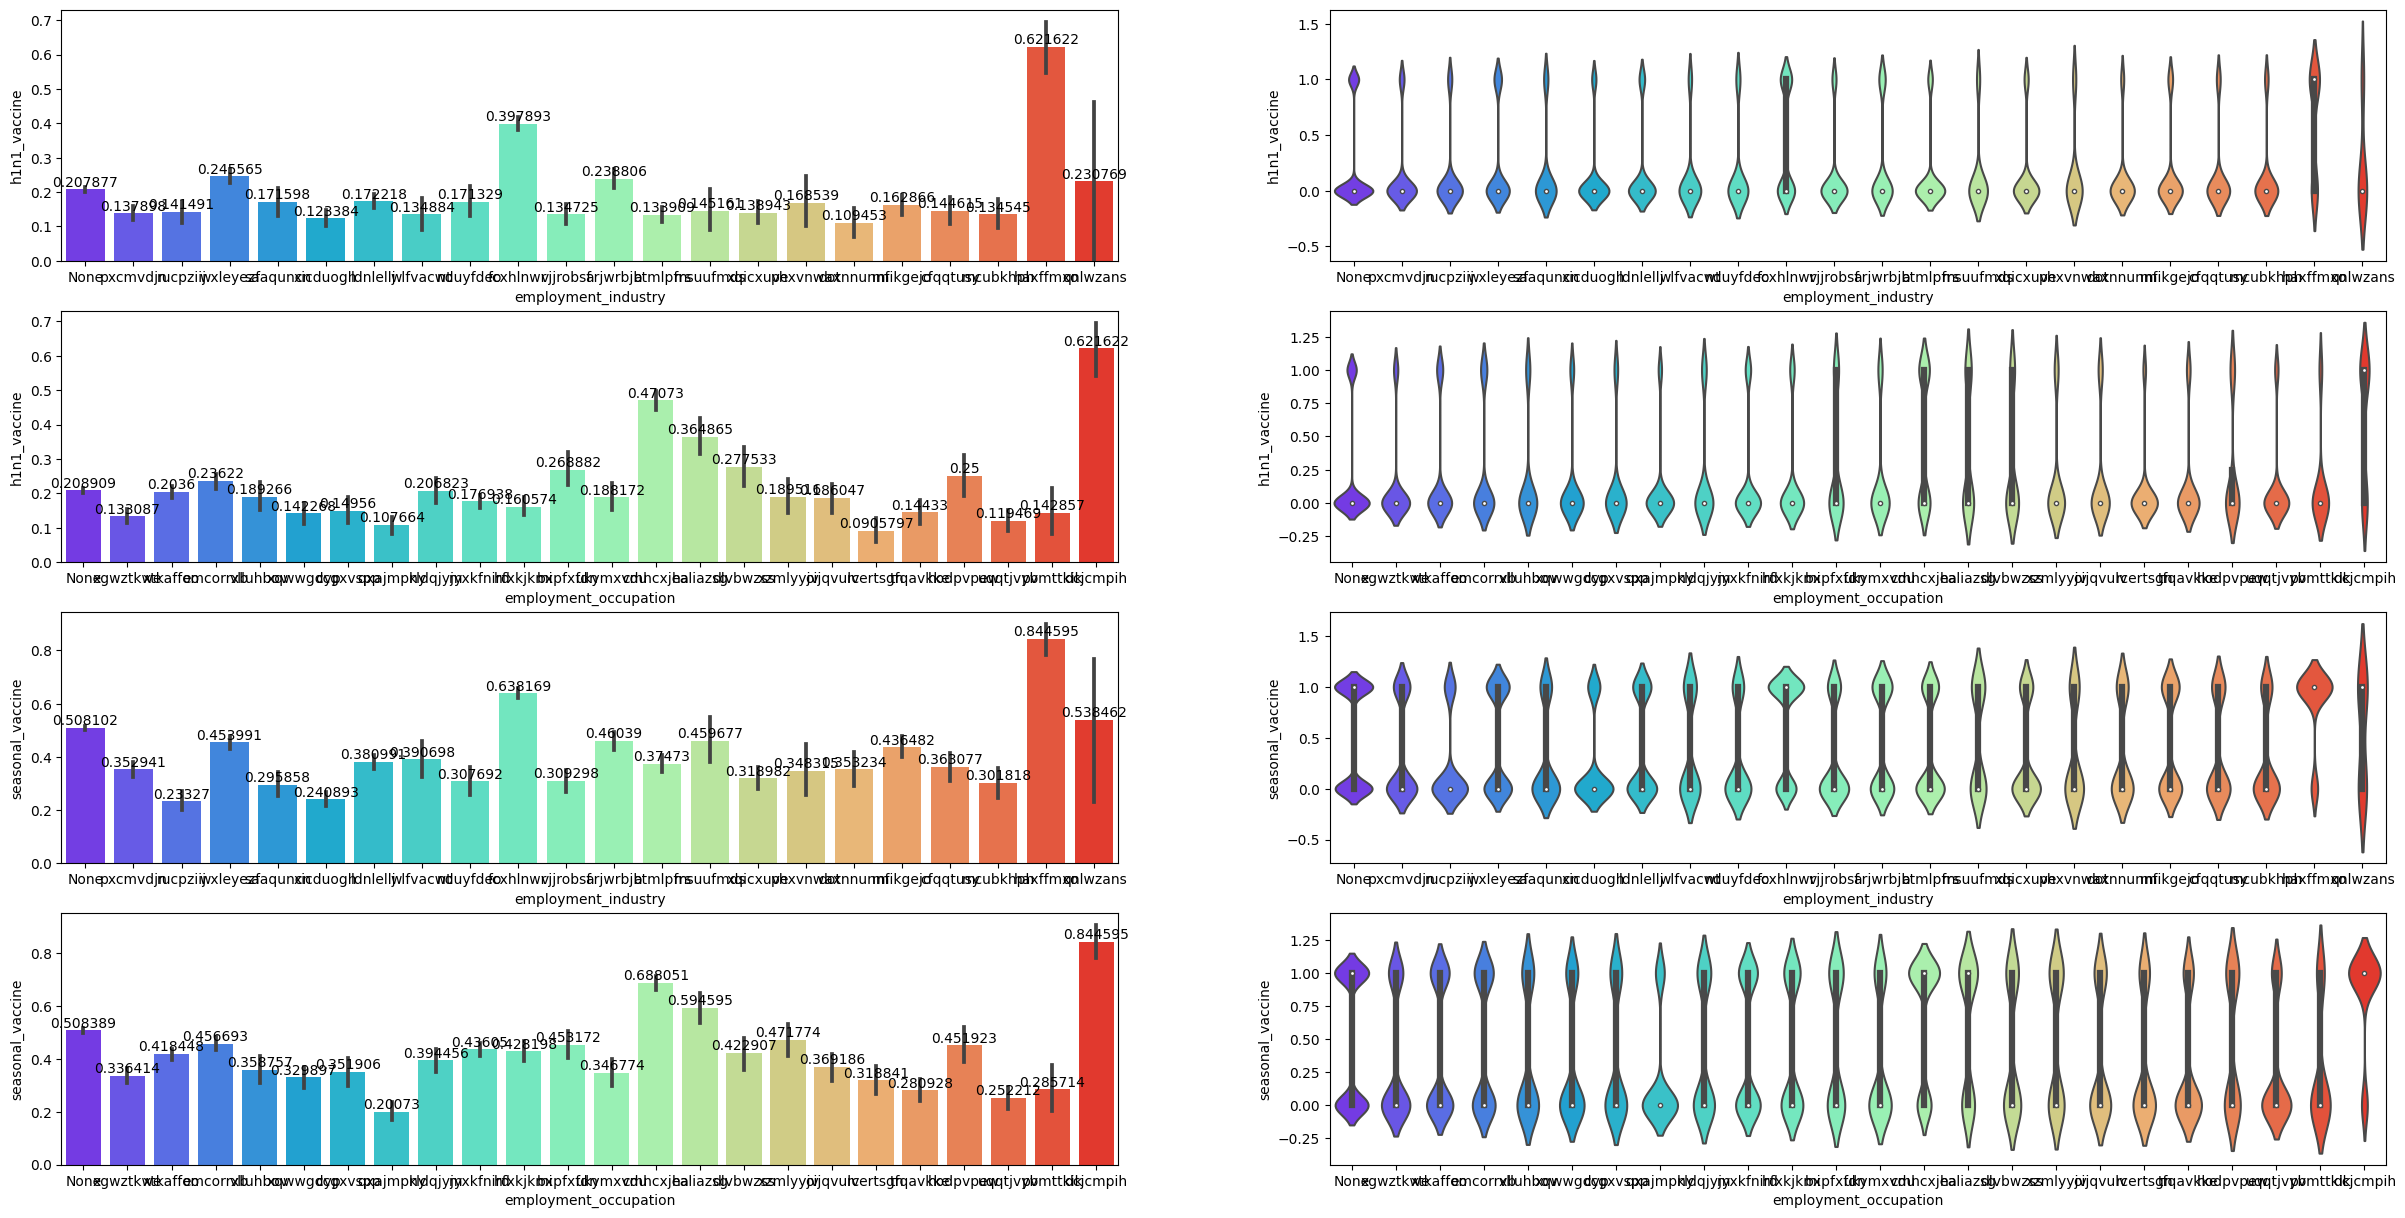

In [35]:
# Create a figure with subplots to plot the barplots and violinplots.
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(30, 15))

# Employment related columns
# Create barplots and violinplots for 'h1n1_vaccine' for each column.
for i, col in enumerate(["employment_industry", "employment_occupation"]):
    bar = sns.barplot(data=train, y='h1n1_vaccine', x=col, ax=ax[i, 0], palette="rainbow")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=train, y='h1n1_vaccine', x=col, ax=ax[i, 1], palette="rainbow")

# Create barplots and violinplots for 'seasonal_vaccine' for each column.
for i, col in enumerate(["employment_industry", "employment_occupation"]):
    bar = sns.barplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i+2, 0], palette="rainbow")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i+2, 1], palette="rainbow")

The bar plot clearly indicates that individuals employed in the "haxffmxo" and "fcxhlnwr" industries have a higher likelihood of receiving both the H1N1 and seasonal vaccines. Similarly, those with employment occupations such as "dcjcmpih" and "cmhcxjea" also exhibit a higher likelihood of receiving both vaccines. These findings emphasize the positive association between specific employment industries and occupations with vaccine uptake for both H1N1 and seasonal viruses.

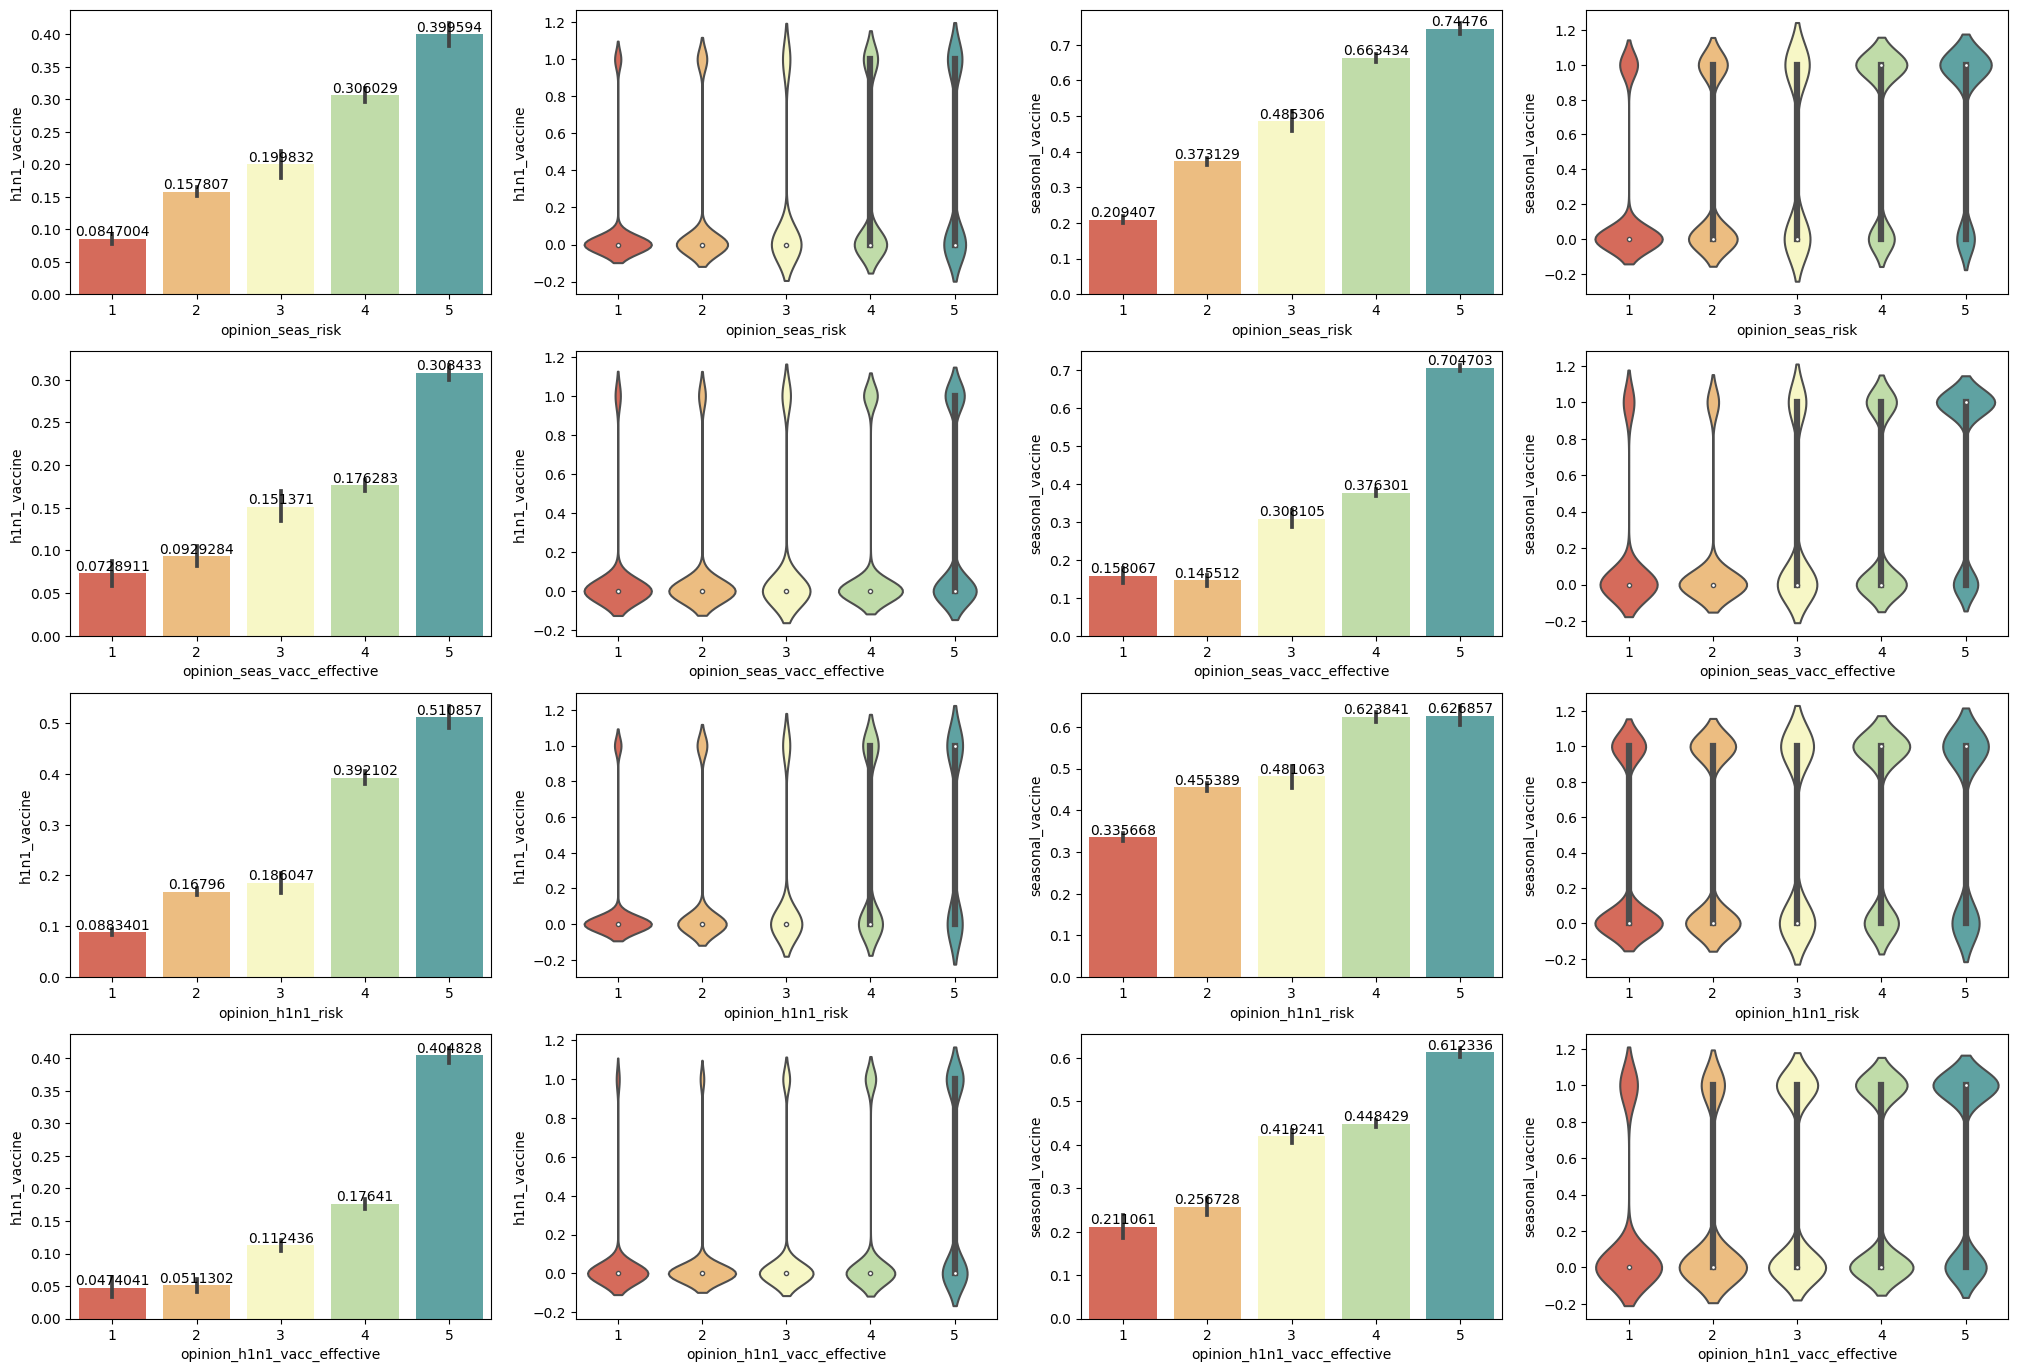

In [36]:
# Create a figure with subplots to plot the barplots and violinplots.
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(25, 17))

# Opinion related columns
for i, col in enumerate(["opinion_seas_risk", "opinion_seas_vacc_effective", "opinion_h1n1_risk", "opinion_h1n1_vacc_effective"]):
    bar = sns.barplot(data=train, y='h1n1_vaccine', x=col, ax=ax[i, 0], palette="Spectral")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=train, y='h1n1_vaccine', x=col, ax=ax[i, 1], palette="Spectral")

    bar = sns.barplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 2], palette="Spectral")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 3], palette="Spectral")

There is a clear relationship observed in the data where individuals who perceive the H1N1 vaccine and seasonal vaccines to be effective are more likely to receive both vaccines. Additionally, individuals who believe that the risk of getting sick with H1N1 flu and seasonal flu without vaccination is higher also demonstrate a higher likelihood of receiving both the H1N1 vaccine and the seasonal vaccine.

These findings highlight the significant impact of perceived vaccine effectiveness and perceived risk of illness on the decision to receive the H1N1 and seasonal vaccines.

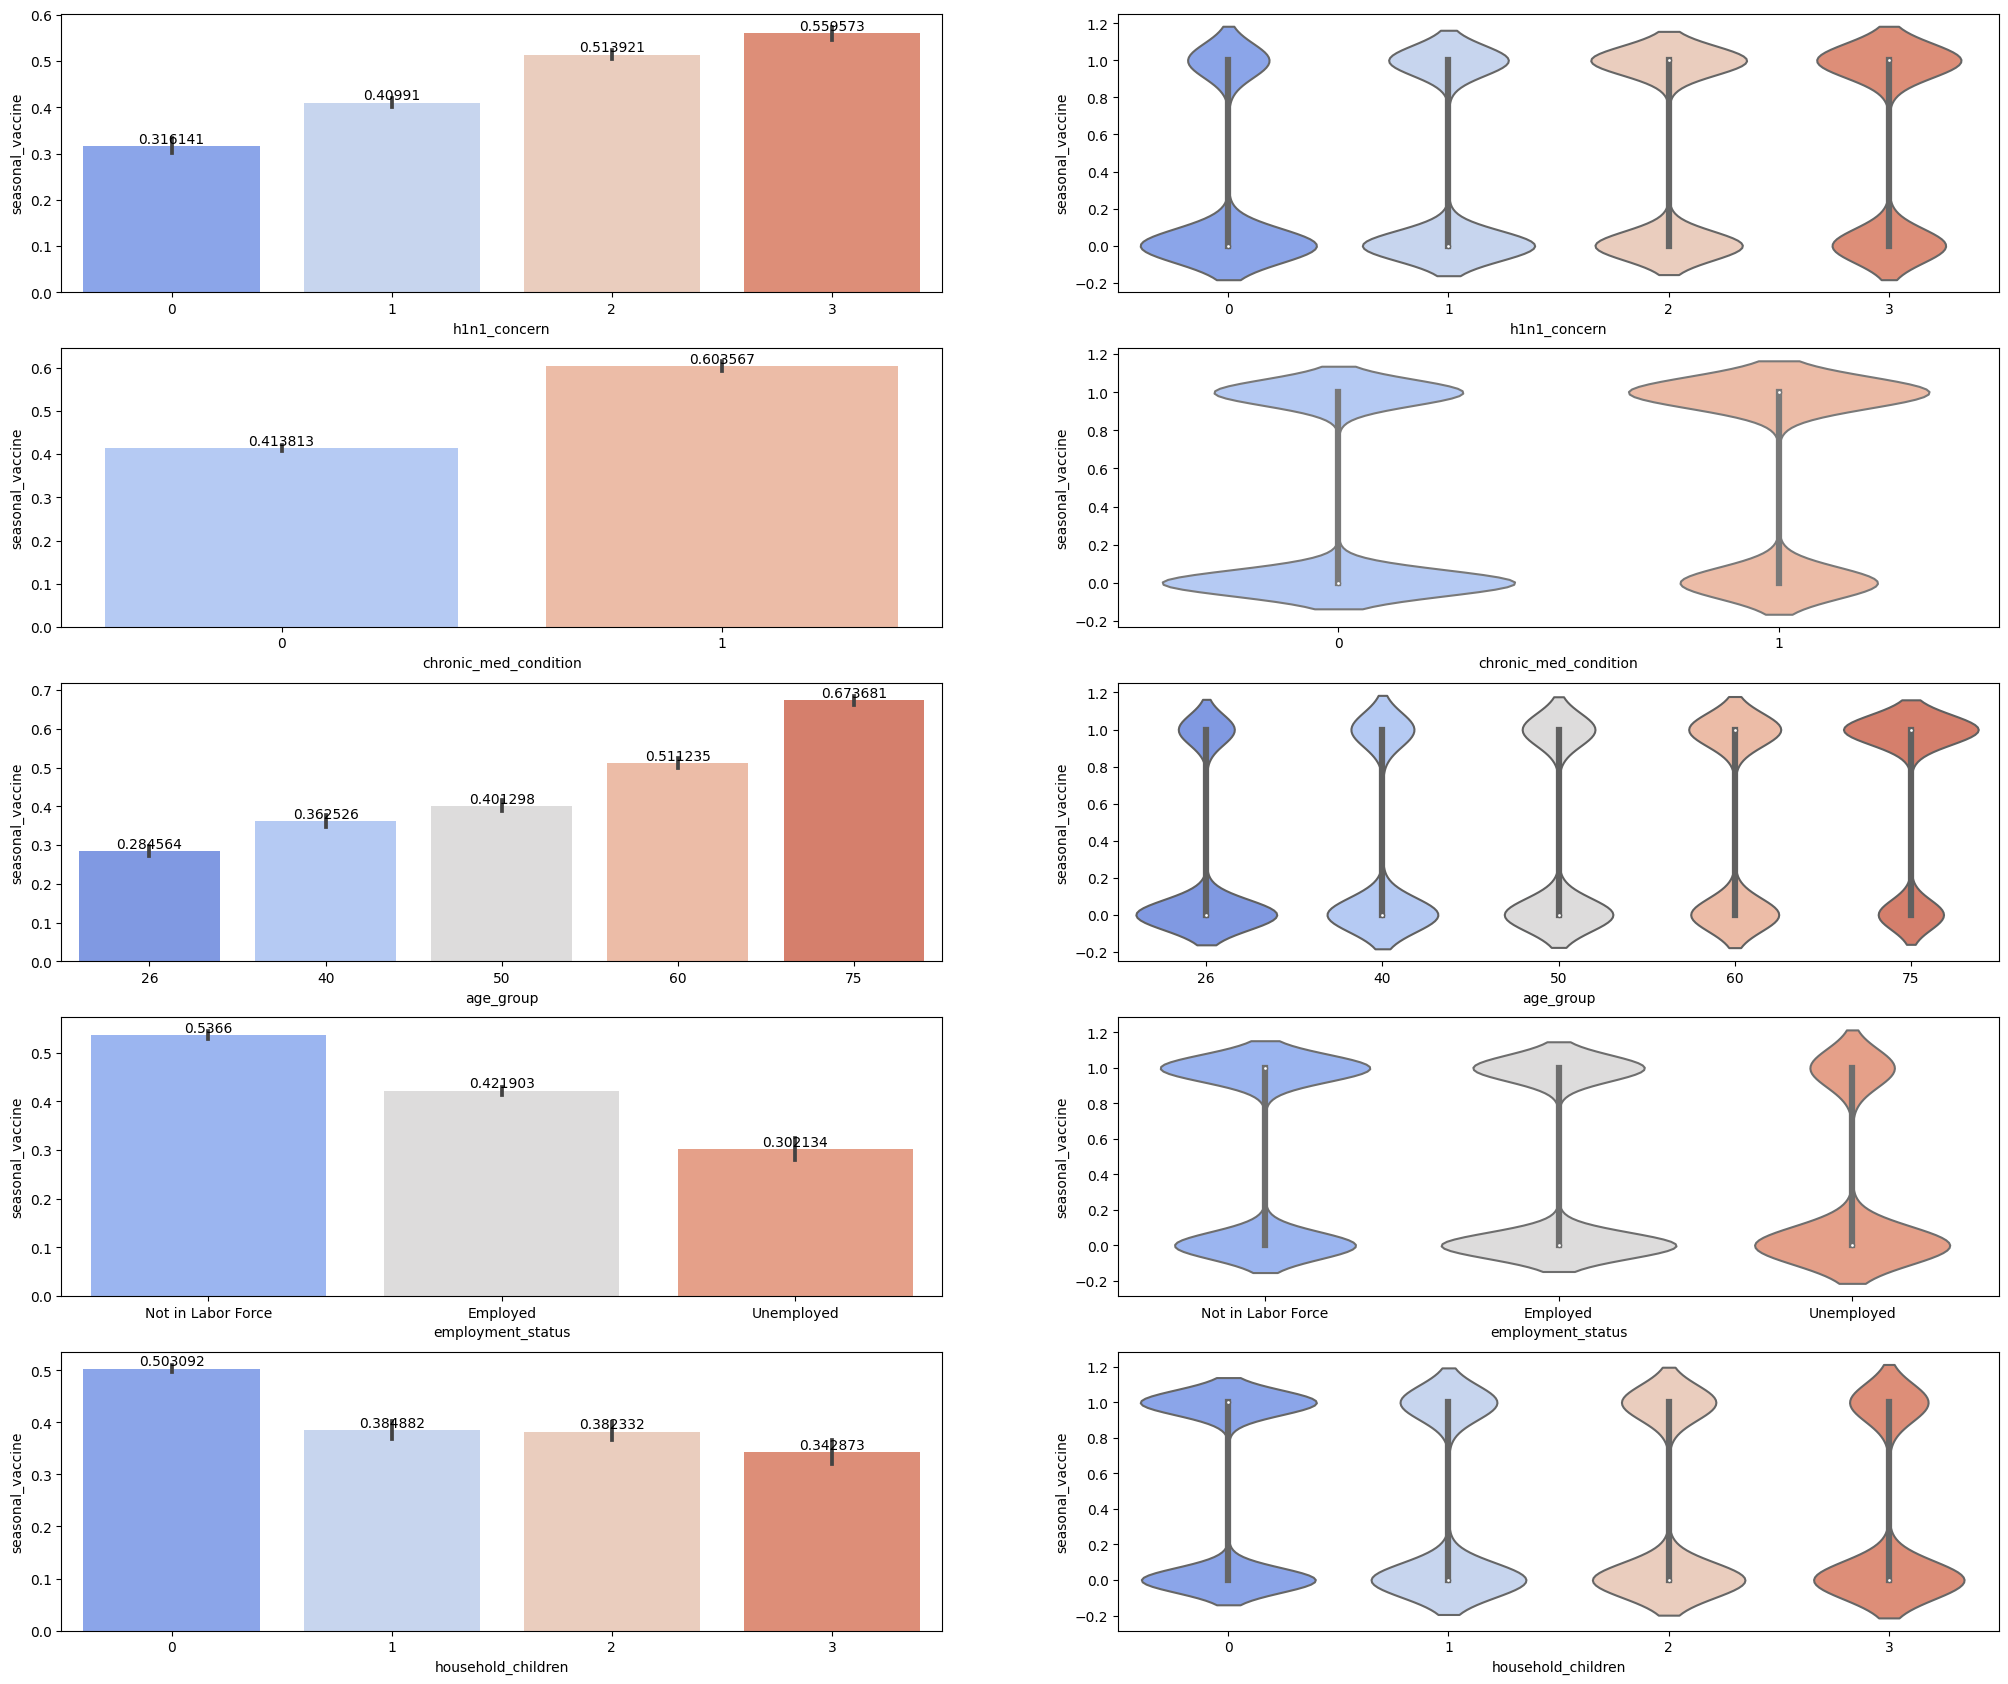

In [37]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(25, 21))

# Other interesting columns
for i, col in enumerate(["h1n1_concern", "chronic_med_condition", "age_group", "employment_status", "household_children"]):
    bar = sns.barplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 0], palette="coolwarm")
    bar.bar_label(bar.containers[0])
    sns.violinplot(data=train, y='seasonal_vaccine', x=col, ax=ax[i, 1], palette="coolwarm")

The bar plot reveals additional insights. Individuals who express concern about the H1N1 flu, have chronic medical conditions, belong to older age groups, are not in the labor force, or have zero children in their household exhibit a higher likelihood of receiving the seasonal vaccine.

These findings suggest that individuals who fall into these categories are more inclined to prioritize their health and take proactive measures by receiving the seasonal vaccine.

### **Summary:**
* People with chronic medical conditions are more likely to take preventive measures against flu-like illnesses.

* Specific employment industries and occupations show higher vaccine uptake for both H1N1 and seasonal flu vaccines.

* Healthcare workers have a higher likelihood of receiving both vaccines.

* Doctor recommendations strongly influence vaccine uptake.

* Perceived vaccine effectiveness and risk of illness are important factors.

* Other factors like concern about H1N1, older age, not being in the labor force, and no children in the household are associated with higher seasonal flu vaccine uptake.

# **3. Feature Engineering**
To further enhance the predictive performance of our model, we will create additional relevant features that capture important patterns and relationships in the data. We propose the following new features:

* `good_behavioral_count` -- represent the cumulative count of flu precaution behaviors practiced by an individual. A higher value would indicate a greater adherence to flu prevention measures.

* `has_doc_recc` -- indicate whether a person has received a recommendation from a doctor for either the H1N1 vaccine or the seasonal flu vaccine (binary). A value of 1 represents that a doctor has recommended at least one of the vaccines, and a value of 0 indicates no doctor recommendation.

Count-based features are beneficial for tree-based models because these models lack the inherent ability to aggregate information across multiple features simultaneously. By introducing count-based features, we allow tree models to leverage valuable insights into the occurrence or frequency of particular events or behaviors.

In [38]:
for df in [train, test]:
    # Calculate the sum of behavioral columns and create a new column "good_behavioral_count"
    df["good_behavioral_count"] = df[behavioral_cols].sum(axis=1)

    for i in range(df.index[0], df.index[-1]+1):
        # Check if both "doctor_recc_h1n1" and "doctor_recc_seasonal" columns have a value of 2 (Unknown)
        if df.loc[i, ["doctor_recc_h1n1", "doctor_recc_seasonal"]].isin([2]).all():
            # If both columns have a value of 2, set "has_doc_recc" to 0
            df.loc[i, "has_doc_recc"] = 0
        else:
            # If any of the columns have a value other than 2, set "has_doc_recc" to 1
            df.loc[i, "has_doc_recc"] = 1

In [39]:
# Append the new ordinal feature to the list of ordinal columns
for new_ord_feature in ["good_behavioral_count", "has_doc_recc"]:
    ordinal_cols.append(new_ord_feature)

We will proceed with encoding the nominal columns in our dataset to ensure that categorical variables are in a suitable format for machine learning algorithms. We will use two different encoding techniques:

* **Ordinal Encoding** -- apply to `age_group` and `education` columns in order to preserve the inherent order or hierarchy present in these columns, allowing the algorithm to understand the relative differences between categories.

* **One-Hot Encoding** -- apply to `race`, `sex`, `marital_status`, `rent_or_own`, `employment_status`, `hhs_geo_region`, `census_msa`, `employment_industry`, `employment_occupation`, `income_poverty` in order to indicate the presence or absence of a category in the observation.

To ensure consistency and avoid discrepancies, we will merge the test and train data before encoding the categorical variables. This merging allows us to encode the variables based on the entire dataset, eliminating any potential issues if a category is present in only one dataset. Once the encoding is complete, we will separate the merged dataset back into their respective test and train datasets.

In [40]:
# Get the number of rows in the train dataframe
train_rows = train.shape[0]

# Concatenate the train and test dataframes vertically
merged_df = pd.concat([train, test])

# Encode object columns using Ordinal Encoding
for col in ["age_group", "education"]:
  merged_df[col], _ = merged_df[col].factorize()

# Encode object columns using One-Hot Encoding
merged_df = pd.get_dummies(merged_df, columns=["race", "sex", "marital_status", "rent_or_own", "employment_status", "hhs_geo_region",
                                               "census_msa", "employment_industry", "employment_occupation", "income_poverty"])

# Separate the merged dataframe back into train and test dataframes
train = merged_df.iloc[:train_rows]
test = merged_df.iloc[train_rows:].drop(columns=["h1n1_vaccine", "seasonal_vaccine"])

In [41]:
train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,household_adults,household_children,h1n1_vaccine,seasonal_vaccine,good_behavioral_count,has_doc_recc,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,marital_status_Married,marital_status_Not Married,marital_status_Unknown,rent_or_own_Own,rent_or_own_Rent,rent_or_own_Unknown,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA,employment_industry_None,employment_industry_arjwrbjb,employment_industry_atmlpfrs,employment_industry_cfqqtusy,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_haxffmxo,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_msuufmds,employment_industry_nduyfdeo,employment_industry_phxvnwax,employment_industry_pxcmvdjn,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_saaquncn,employment_industry_vjjrobsf,employment_industry_wlfvacwt,employment_industry_wxleyezf,employment_industry_xicduogh,employment_industry_xqicxuve,employment_occupation_None,employment_occupation_bxpfxfdn,employment_occupation_ccgxvspp,employment_occupation_cmhcxjea,employment_occupation_dcjcmpih,employment_occupation_dlvbwzss,employment_occupation_emcorrxb,employment_occupation_haliazsg,employment_occupation_hfxkjkmi,employment_occupation_hodpvpew,employment_occupation_kldqjyjy,employment_occupation_mxkfnird,employment_occupation_oijqvulv,employment_occupation_pvmttkik,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,income_poverty_Unknown
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,3,1,2,2,1,2,0,0,0,0,0.0,0.0,2,1.0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,3,2,0,1,0,1,0,1,1,0,0,0,0,0,1,5,4,4,4,2,4,1,1,0,0,0.0,1.0,4,1.0,0,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,1,0,1,0,0,0,0,0,2,2,1,0,0,2,3,1,1,4,1,2,2,2,2,0,0.0,0.0,1,0.0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
3,1,1,0,1,0,1,1,0,0,0,1,1,0,0,2,3,3,5,5,4,1,3,1,0,0,0.0,1.0,3,1.0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,1,0,1,0,1,1,0,1,0,0,0,0,0,2,3,3,2,3,1,4,4,3,1,0,0.0,0.0,4,1.0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


We will employ mutual information to measure the relationship between two columns. It quantifies how knowing one variable reduces uncertainty about the other. Higher mutual information indicates a stronger relationship, while lower values indicate weaker or no relationship. This helps confirm the relationships found during EDA.

In [42]:
# Mutual Information function to calculate MI scores
def make_mi_scores(X, y, discrete_features):
    # Calculate Mutual Information (MI) scores between features (X) and target (y)
    mi_scores = mic(X, y, discrete_features=discrete_features)
    # Convert the MI scores to a Pandas Series with feature names as index and sort in descending order
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns).sort_values(ascending=False)
    return mi_scores

# Create a copy of the train dataframe as X
X = train.copy()

# Separate the target variables from X and store them in y_h1n1 and y_seas
y_h1n1 = X.pop("h1n1_vaccine")
y_seas = X.pop("seasonal_vaccine")

# Identify the discrete features in X (features with dtype 'int64')
discrete_features = (X.dtypes == "int64")

In [43]:
# H1N1 MI Score
mi_scores_h1n1 = make_mi_scores(X, y_h1n1, discrete_features)

# Convert the MI scores into a transposed DataFrame
pd.DataFrame(mi_scores_h1n1).T

,doctor_recc_h1n1,opinion_h1n1_risk,opinion_h1n1_vacc_effective,opinion_seas_risk,health_insurance,doctor_recc_seasonal,opinion_seas_vacc_effective,employment_occupation_cmhcxjea,health_worker,employment_industry_fcxhlnwr,has_doc_recc,h1n1_concern,h1n1_knowledge,rent_or_own_Rent,employment_industry_None,"income_poverty_> $75,000",marital_status_Married,employment_status_Employed,race_Black,opinion_h1n1_sick_from_vacc,"income_poverty_<= $75,000, Above Poverty",chronic_med_condition,good_behavioral_count,employment_occupation_None,census_msa_Non-MSA,race_Hispanic,sex_Female,employment_occupation_tfqavkke,income_poverty_Unknown,employment_occupation_haliazsg,behavioral_wash_hands,race_White,employment_industry_rucpziij,employment_industry_msuufmds,behavioral_touch_face,hhs_geo_region_kbazzjca,hhs_geo_region_lzgpxyit,education,rent_or_own_Own,hhs_geo_region_bhuqouqj,behavioral_face_mask,child_under_6_months,employment_industry_haxffmxo,"census_msa_MSA, Principle City",employment_industry_dotnnunm,employment_occupation_mxkfnird,employment_industry_atmlpfrs,employment_industry_xqicxuve,employment_occupation_xzmlyyjv,employment_occupation_xtkaffoo,age_group,behavioral_avoidance,employment_occupation_xgwztkwe,employment_occupation_qxajmpny,employment_occupation_rcertsgn,"census_msa_MSA, Not Principle City",employment_industry_wlfvacwt,opinion_seas_sick_from_vacc,employment_occupation_vlluhbov,income_poverty_Below Poverty,behavioral_antiviral_meds,household_adults,rent_or_own_Unknown,hhs_geo_region_mlyzmhmf,hhs_geo_region_dqpwygqj,employment_occupation_oijqvulv,employment_industry_phxvnwax,employment_occupation_emcorrxb,employment_occupation_bxpfxfdn,marital_status_Unknown,behavioral_outside_home,behavioral_large_gatherings,race_Other or Multiple,household_children,employment_status_Not in Labor Force,employment_occupation_xqwwgdyp,employment_status_Unemployed,hhs_geo_region_atmpeygn,employment_industry_arjwrbjb,marital_status_Not Married,employment_occupation_uqqtjvyb,sex_Male,employment_occupation_ukymxvdu,hhs_geo_region_fpwskwrf,hhs_geo_region_lrircsnp,hhs_geo_region_oxchjgsf,employment_occupation_pvmttkik,hhs_geo_region_qufhixun,employment_industry_nduyfdeo,employment_occupation_kldqjyjy,employment_industry_pxcmvdjn,employment_occupation_hfxkjkmi,employment_industry_cfqqtusy,employment_occupation_dlvbwzss,employment_occupation_dcjcmpih,employment_occupation_ccgxvspp,employment_industry_ldnlellj,employment_industry_xicduogh,employment_industry_wxleyezf,employment_industry_mcubkhph,employment_industry_vjjrobsf,employment_industry_saaquncn,employment_industry_mfikgejo,employment_industry_qnlwzans,employment_occupation_hodpvpew
MI Scores,0.068163,0.050324,0.044591,0.033334,0.030916,0.024471,0.019502,0.015579,0.012285,0.010322,0.008947,0.007561,0.007319,0.006171,0.006023,0.005621,0.005221,0.005107,0.004622,0.004543,0.004367,0.004286,0.004246,0.003751,0.00351,0.003386,0.003324,0.003323,0.003271,0.003246,0.002985,0.00266,0.002647,0.002609,0.002585,0.002493,0.002491,0.002444,0.002424,0.002294,0.00226,0.002052,0.001869,0.001734,0.001619,0.001584,0.001504,0.001398,0.001326,0.001299,0.001293,0.001124,0.00111,0.001108,0.001091,0.000875,0.000862,0.000859,0.000806,0.000803,0.000755,0.000531,0.000513,0.000483,0.000443,0.000433,0.00039,0.000359,0.000347,0.000326,0.000242,0.000163,0.000087,0.000048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Seasonal MI Score
mi_scores_seas = make_mi_scores(X, y_seas, discrete_features)

# Convert the MI scores into a transposed DataFrame
pd.DataFrame(mi_scores_seas).T

,opinion_seas_vacc_effective,opinion_seas_risk,doctor_recc_seasonal,age_group,opinion_h1n1_risk,opinion_h1n1_vacc_effective,doctor_recc_h1n1,chronic_med_condition,health_insurance,race_White,h1n1_concern,sex_Female,rent_or_own_Own,good_behavioral_count,employment_status_Not in Labor Force,employment_status_Employed,health_worker,employment_industry_None,h1n1_knowledge,employment_occupation_cmhcxjea,behavioral_touch_face,employment_industry_saaquncn,household_children,behavioral_wash_hands,"census_msa_MSA, Not Principle City",rent_or_own_Rent,hhs_geo_region_lzgpxyit,opinion_seas_sick_from_vacc,employment_occupation_bxpfxfdn,employment_occupation_xqwwgdyp,employment_occupation_mxkfnird,marital_status_Married,hhs_geo_region_dqpwygqj,income_poverty_Below Poverty,employment_occupation_None,race_Other or Multiple,marital_status_Unknown,hhs_geo_region_bhuqouqj,hhs_geo_region_kbazzjca,sex_Male,education,"income_poverty_<= $75,000, Above Poverty",employment_status_Unemployed,has_doc_recc,behavioral_avoidance,census_msa_Non-MSA,employment_occupation_qxajmpny,employment_industry_cfqqtusy,employment_industry_xicduogh,hhs_geo_region_oxchjgsf,employment_industry_vjjrobsf,hhs_geo_region_fpwskwrf,employment_industry_msuufmds,household_adults,employment_occupation_rcertsgn,behavioral_large_gatherings,employment_industry_pxcmvdjn,employment_occupation_uqqtjvyb,rent_or_own_Unknown,employment_industry_haxffmxo,employment_occupation_hfxkjkmi,behavioral_outside_home,hhs_geo_region_mlyzmhmf,behavioral_face_mask,employment_occupation_pvmttkik,opinion_h1n1_sick_from_vacc,marital_status_Not Married,employment_occupation_oijqvulv,employment_occupation_emcorrxb,race_Hispanic,employment_occupation_tfqavkke,employment_industry_nduyfdeo,employment_occupation_xgwztkwe,child_under_6_months,hhs_geo_region_lrircsnp,behavioral_antiviral_meds,employment_occupation_kldqjyjy,"census_msa_MSA, Principle City",employment_occupation_ukymxvdu,employment_occupation_vlluhbov,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv,"income_poverty_> $75,000",race_Black,employment_occupation_hodpvpew,employment_occupation_ccgxvspp,employment_occupation_haliazsg,hhs_geo_region_qufhixun,employment_industry_arjwrbjb,employment_industry_atmlpfrs,employment_industry_dotnnunm,employment_industry_fcxhlnwr,employment_industry_ldnlellj,employment_industry_mcubkhph,employment_industry_mfikgejo,employment_industry_phxvnwax,employment_occupation_dlvbwzss,employment_industry_qnlwzans,employment_industry_rucpziij,employment_industry_wlfvacwt,employment_industry_wxleyezf,hhs_geo_region_atmpeygn,employment_industry_xqicxuve,employment_occupation_dcjcmpih,income_poverty_Unknown
MI Scores,0.082803,0.078227,0.066719,0.041567,0.024315,0.023795,0.020623,0.014386,0.014376,0.013634,0.012536,0.011256,0.010012,0.009904,0.009004,0.008317,0.008104,0.007676,0.007386,0.007352,0.00725,0.007162,0.007108,0.006413,0.005641,0.005234,0.005219,0.004624,0.004454,0.004449,0.004173,0.003814,0.003776,0.003742,0.00371,0.003697,0.00357,0.003518,0.003409,0.003343,0.00326,0.003112,0.003077,0.002975,0.002914,0.002899,0.002872,0.002854,0.002838,0.002731,0.00269,0.002576,0.002459,0.002434,0.002227,0.002029,0.002026,0.002019,0.001801,0.001693,0.001541,0.001418,0.001315,0.001248,0.001214,0.001182,0.000911,0.000774,0.000576,0.000537,0.00046,0.000453,0.000192,0.00009,0.000063,0.000018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **4. Modeling**
To start modeling for the classification problem, we'll choose the best model for both the h1n1_vaccine and seasonal_vaccine targets. Then, we'll test the selected model with default parameters and evaluate its performance using the ROC AUC metric.

By starting with the default parameters, we can establish a baseline performance for the model. This will allow us to compare and assess the effectiveness of subsequent parameter tuning and optimizations.

In [45]:
models = {
    # "lr": LogisticRegression(random_state=42), # Error
    "dtc": DecisionTreeClassifier(random_state=42),
    "rfc": RandomForestClassifier(random_state=42),
    "knn": KNeighborsClassifier(),
    "gnb": GaussianNB(),
    "svc": SVC(random_state=42),
    # 'xgboost': xgb.XGBClassifier(random_state=42), # Error
    # 'lightgbm': lgbm.LGBMClassifier(random_state=42), # Error
    'catboost': cb.CatBoostClassifier(verbose=0, random_state=42),
    'nn': MLPClassifier(random_state=42, hidden_layer_sizes=(10, 10), max_iter=500)
}

We will utilize k-fold cross-validation to obtain a more reliable and robust estimate of our model's performance. By leveraging k-fold cross-validation, we can gain a more comprehensive understanding of our model's effectiveness and its ability to generalize to unseen data.

In [46]:
# Function for performing k-fold cross-validation
def kfold_cv(model, X, y):
    # Define KFold cross-validation with 5 splits, random state of 42, and shuffling of data
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    scores = []  # List to store the evaluation scores

    # Iterate over the train and validation splits
    for train_idx, test_idx in kf.split(X, y):
        # Split the data into training and validation sets based on the indices
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the validation data
        predictions = model.predict(X_val)

        # Calculate the evaluation score (here, using RAS macro-average)
        ras_score = ras(y_val, predictions, average="macro")

        # Append the score to the list of scores
        scores.append(ras_score)
    return np.mean(scores) # Return the mean of the scores as the overall evaluation score

# Prepare the input features and target variables for H1N1 vaccine prediction
X_h1n1 = train.drop(["h1n1_vaccine", "seasonal_vaccine"], axis=1)
y_h1n1 = train.pop("h1n1_vaccine")

# Prepare the input features and target variables for seasonal flu vaccine prediction
X_seas = train.drop("seasonal_vaccine", axis=1)
y_seas = train.pop("seasonal_vaccine")

In [47]:
# H1N1 Vaccine
# Iterate over the models dictionary
for name, model in models.items():
    # Perform k-fold cross-validation and obtain the evaluation score
    score = kfold_cv(model, X_h1n1, y_h1n1)
    # Print the model name and its corresponding score
    print(f"{name}: {score}")

dtc: 0.6806853230763787
rfc: 0.694912209992445
knn: 0.64765706783525
gnb: 0.660170583324031
svc: 0.6862238701125492
catboost: 0.7309580872149064
nn: 0.7266257333969881


In [48]:
# Seasonal Vaccine
for name, model in models.items():
    score = kfold_cv(model, X_seas, y_seas)
    print(f"{name}: {score}")

dtc: 0.6818981780307172
rfc: 0.7748969419806162
knn: 0.710929766555078
gnb: 0.6473026528245842
svc: 0.7749401964035405
catboost: 0.7858935430657815
nn: 0.7649068650606677


The results indicate that the CatBoost model consistently outperforms the other models, yielding higher scores. This suggests that the CatBoost model is better suited for our classification task and exhibits superior predictive performance compared to the alternative models.

Now, we will proceed to utilize CatBoost with tuned parameters obtained from Optuna to further enhance our prediction score. By incorporating the optimized parameter settings, we aim to improve the performance of the CatBoost model and achieve an even higher prediction score.

In [49]:
h1n1_param = {
    'iterations': 600,  # Number of boosting iterations
    'learning_rate': 0.02857091731949716,  # Learning rate for boosting
    'random_strength': 1,  # Random strength for boosting
    'bagging_temperature': 2,  # Bagging temperature for boosting
    'max_bin': 21,  # Maximum number of bins for numerical features
    'grow_policy': 'Lossguide',  # Tree growth policy
    'min_data_in_leaf': 18,  # Minimum number of samples required in a leaf
    'max_depth': 6,  # Maximum depth of trees
    'l2_leaf_reg': 30.38300354991344,  # L2 regularization coefficient
    'one_hot_max_size': 13,  # Maximum size of one-hot encoding for categorical features
    'auto_class_weights': 'Balanced',  # Automatic class weights adjustment
    "verbose": 0,  # Verbosity level
}

seas_param = {
    'iterations': 800,  # Number of boosting iterations
    'learning_rate': 0.017179768319739466,  # Learning rate for boosting
    'random_strength': 0,  # Random strength for boosting
    'bagging_temperature': 7,  # Bagging temperature for boosting
    'max_bin': 106,  # Maximum number of bins for numerical features
    'grow_policy': 'Lossguide',  # Tree growth policy
    'min_data_in_leaf': 20,  # Minimum number of samples required in a leaf
    'max_depth': 4,  # Maximum depth of trees
    'l2_leaf_reg': 45.5914670615121,  # L2 regularization coefficient
    'one_hot_max_size': 8,  # Maximum size of one-hot encoding for categorical features
    'auto_class_weights': 'Balanced',  # Automatic class weights adjustment
    "verbose": 0,  # Verbosity level
}

# Create a CatBoostClassifier model with the H1N1 vaccine parameters and fit it to the data
model_h1n1 = cb.CatBoostClassifier(**h1n1_param)
model_h1n1.fit(X_h1n1, y_h1n1)

# Create a CatBoostClassifier model with the seasonal flu vaccine parameters and fit it to the data
model_seas = cb.CatBoostClassifier(**seas_param)
model_seas.fit(X_seas, y_seas)

In [50]:
score = kfold_cv(model_h1n1, X_h1n1, y_h1n1)
print(f"Catboost H1N1: {score}")

Catboost H1N1: 0.786985730539338


In [51]:
score = kfold_cv(model_seas, X_seas, y_seas)
print(f"CatBoost Seasonal: {score}")

CatBoost Seasonal: 0.7866634782496178


By incorporating the optimized parameters into CatBoost, we observe a significant increase in the prediction score. With this improved performance, we can now proceed to follow the prescribed format for the submission file in this competition.

In [52]:
# Create a DataFrame for the submission
submission = pd.DataFrame({
    "respondent_id": test.index,  # Use the respondent IDs from the test data
    "h1n1_vaccine": model_h1n1.predict_proba(test)[:, 1],  # Use the probability of the positive class for H1N1 vaccine
    "seasonal_vaccine": model_seas.predict_proba(test)[:, 1]  # Use the probability of the positive class for seasonal flu vaccine
})

# Save the submission DataFrame to a CSV file without including the index
submission.to_csv("submission.csv", index=False)
submission.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.323651,0.219066
1,26708,0.150039,0.030736
2,26709,0.436677,0.705002
3,26710,0.849631,0.887812
4,26711,0.593263,0.455232


<hr><hr>

# **Hyperparameter Tuning**
We will utilize Optuna for hyperparameter tuning of our models, specifically focusing on the CatBoost algorithm. This technique has shown significant improvement in our ROC AUC prediction score, with an increase of over 0.05.

By leveraging Optuna's optimization capabilities, we aim to fine-tune the hyperparameters of the CatBoost model to maximize its predictive performance and enhance the overall accuracy of our predictions.

In [ ]:
# Function for tuning a model using k-fold cross-validation
def tune_kfold_cv(model, X, y, metric, n_folds=69):
    # Create a k-fold cross-validation object with specified number of folds
    skfold = KFold(n_splits=n_folds, random_state=0, shuffle=True)
    
    # List to store the scores obtained from each fold
    scores = []
    
    # Iterate over the folds
    for train_index, test_index in skfold.split(X, y):
        # Split the data into training and testing sets based on the fold indices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data and evaluate it on the testing data
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
        predictions = model.predict(X_test.values)
        
        # Calculate the score using the specified evaluation metric
        score = metric(y_test, predictions, average="macro")
        
        # Append the score to the list of scores
        scores.append(score)
        
        # Print the ROC AUC score for the current fold
        print(f'ROC AUC: {score:.3f}')
    
    # Return the list of scores
    return scores

In [ ]:
# Objective function for hyperparameter optimization using Optuna
def objective(trial, data=X_h1n1, target=y_h1n1):
    # Define the hyperparameter search space using trial suggestions
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.1),
        'random_strength': trial.suggest_int('random_strength', 0.0, 10.0),
        'bagging_temperature': trial.suggest_int('bagging_temperature', 0.0, 10.0),
        'max_bin': trial.suggest_int('max_bin', 1, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 16),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['None', 'Balanced', 'SqrtBalanced']),
        'verbose': 0,
        'early_stopping_rounds': 200,
    }
    
    # Create a CatBoostClassifier with the suggested hyperparameters
    model = cb.CatBoostClassifier(**params)
    
    # Perform k-fold cross-validation with the tuned model and calculate the average score
    scores = tune_kfold_cv(model, X_h1n1, y_h1n1, ras, 8)
    return np.sum(scores) / 8

In [ ]:
# Create an Optuna study with the direction set to maximize
study = optuna.create_study(direction='maximize')

# Run the optimization process using the objective function defined earlier, with a specified number of trials
study.optimize(objective, n_trials=30)

# Print the number of finished trials (i.e., the number of trials that have been executed)
print('Number of finished trials:', len(study.trials))

# Print the best trial's parameters, which correspond to the set of hyperparameters that yielded the highest objective value
print('Best trial:', study.best_trial.params)

In [ ]:
# Assign the best parameters found during optimization to a variable
parameter_tuned = study.best_trial.params

# Create a CatBoostClassifier model using the best parameters
model = cb.CatBoostClassifier(**parameter_tuned)

# Calculate the score using k-fold cross-validation with the model and the H1N1 dataset
score = kfold_cv(model, X_h1n1, y_h1n1)

# Print the score obtained from k-fold cross-validation
print(f"CatBoost H1N1: {score}")

In [ ]:
# Define the objective function for parameter optimization
def objective(trial, data=X_seas, target=y_seas):
    # Define the parameter space to search within
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.1),
        'random_strength': trial.suggest_int('random_strength', 0.0, 10.0),
        'bagging_temperature': trial.suggest_int('bagging_temperature', 0.0, 10.0),
        'max_bin': trial.suggest_int('max_bin', 1, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 100.0),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 16),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['None', 'Balanced', 'SqrtBalanced']),
        'verbose': 0,
        'early_stopping_rounds': 200,
    }
    # Create a CatBoostClassifier model with the suggested parameters
    model = cb.CatBoostClassifier(**params)
  
    # Perform k-fold cross-validation and calculate scores
    scores = tune_kfold_cv(model, X_seas, y_seas, ras, 8)
  
    # Return the average of the scores
    return np.sum(scores) / 8

In [ ]:
# Create an Optuna study object for parameter optimization
study = optuna.create_study(direction='maximize')

# Perform the optimization by running the objective function for a specified number of trials
study.optimize(objective, n_trials=30)

# Print the number of finished trials
print('Number of finished trials:', len(study.trials))

# Print the best trial's parameters
print('Best trial:', study.best_trial.params)

In [ ]:
# Retrieve the tuned parameters from the best trial of the study
parameter_tuned = study.best_trial.params

# Create a CatBoostClassifier model using the tuned parameters
model = cb.CatBoostClassifier(**parameter_tuned)

# Compute the score using k-fold cross-validation with the tuned model
score = kfold_cv(model, X_seas, y_seas)

# Print the score for the CatBoost model on the seasonal vaccine prediction
print(f"CatBoost Seas: {score}")